[View in Colaboratory](https://colab.research.google.com/github/ale93111/Unet_dsb2018/blob/master/Unet_weighted_valid_dsb2018.ipynb)

In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [1]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pwd

/content


In [0]:
#!fusermount -u drive
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("drive/kaggle/Unet_dsb2018")

In [5]:
#!pip install --upgrade pip
!pip install tqdm
!pip install tensorflow
!pip install keras
!pip install imgaug

    100% |████████████████████████████████| 51kB 2.1MB/s 
    100% |████████████████████████████████| 563kB 6.1MB/s 
  Running setup.py bdist_wheel for imgaug ... - \ done
  Stored in directory: /content/.cache/pip/wheels/31/48/c8/ca3345e8582a078de94243996e148377ef66fdb845557bae0b
Successfully built imgaug


In [6]:
import os

NAME = 'bowl'

# Root directory of the project
ROOT_DIR = os.getcwd()

print(ROOT_DIR)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

#Dataset directory
dataset_path = os.path.join(ROOT_DIR, "RCNN_dataset_512_labels")

/content/drive/kaggle/Unet_dsb2018


In [0]:
import numpy as np
from functools import partial, update_wrapper

#partial name fix
def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func

def pad2n(image,npad=32):
    h, w = image.shape[:2]
    if h % npad > 0:
        max_h = h - (h % npad) + npad
        top_pad = (max_h - h) // 2
        bottom_pad = max_h - h - top_pad
    else:
        top_pad = bottom_pad = 0
    # Width
    if w % npad > 0:
        max_w = w - (w % npad) + npad
        left_pad = (max_w - w) // 2
        right_pad = max_w - w - left_pad
    else:
        left_pad = right_pad = 0

    padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
    image = np.pad(image, padding, mode='reflect')
    window = (slice(top_pad, h + top_pad),slice(left_pad, w + left_pad))
    
    return image, window
  
def label_to_masks(labels):
    h, w = labels.shape
    n_msk = labels.max()
    masks = np.empty((h,w,n_msk),dtype=np.bool)
    for i in range(n_msk):
        masks[:,:,i] = labels==i+1
    return masks
  
def masks_to_label(msk):
    h, w, _ = msk.shape
    labels = np.zeros((h, w), dtype=np.uint16)
    for index in range(0, msk.shape[-1]):
        labels[msk[:,:,index] > 0] = index + 1
    return labels

In [8]:
import tensorflow as tf
#from tensorflow.python import keras
#from tensorflow.python.keras import layers as KL
#from tensorflow.python.keras import backend as K
import keras
import keras.backend as K
import keras.layers as KL
import keras.models as KM
import keras.utils as KU
import keras.losses as KLO
from keras.optimizers import Adam, SGD

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0) #AGGIUNTO AXIS=0

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * KLO.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def weighted_loss(y_true,y_pred, weights):
    _epsilon = 10e-8
    y_pred = tf.clip_by_value(y_pred, _epsilon, 1. - _epsilon)
    
    #loss_map = K.binary_crossentropy(y_true, y_pred, from_logits=False) #change if softmax is present or not in the net
    #weighted_loss = loss_map*weights#[:,:,:,np.newaxis]
    #loss=K.mean(weighted_loss)

    return - tf.reduce_sum(y_true * weights *  tf.log(y_pred) +
                          (1 - y_true)  *  tf.log(1 - y_pred),
                          len(y_pred.get_shape()) - 1)

def Unet(img_size=None, GPU_COUNT=1, pad='same'):
  
    inputs         = KL.Input((img_size, img_size, 3))
    
    wgt_size = 228 if img_size is not None else None
    weights_tensor = KL.Input((wgt_size, wgt_size, 1))
    
    s = KL.Lambda(lambda x: x/128.0 - 1.0)(inputs)
    
    if img_size is not None:
        pad = 'valid'

    #TODO: make more general
    c1 = KL.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding=pad)(s)
    #print("c1 shape:",c1.shape)
    n1 = KL.BatchNormalization(axis=3)(c1)
    a1 = KL.Activation("elu")(n1)
    c1 = KL.Dropout(0.2)(a1)
    c1 = KL.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding=pad)(c1)
    #print("c1 shape:",c1.shape)
    n1 = KL.BatchNormalization(axis=3)(c1)
    a1 = KL.Activation("elu")(n1)
    p1 = KL.MaxPooling2D((2, 2))(a1)

    c2 = KL.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding=pad)(p1)
    #print("c2 shape:",c2.shape)
    n2 = KL.BatchNormalization(axis=3)(c2)
    a2 = KL.Activation("elu")(n2)
    c2 = KL.Dropout(0.2)(a2)
    c2 = KL.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding=pad)(c2)
    #print("c2 shape:",c2.shape)
    n2 = KL.BatchNormalization(axis=3)(c2)
    a2 = KL.Activation("elu")(n2)
    p2 = KL.MaxPooling2D((2, 2))(a2)

    c3 = KL.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding=pad)(p2)
    #print("c3 shape:",c3.shape)
    n3 = KL.BatchNormalization(axis=3)(c3)
    a3 = KL.Activation("elu")(n3)
    c3 = KL.Dropout(0.3)(a3)
    c3 = KL.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding=pad)(c3)
    #print("c3 shape:",c3.shape)
    n3 = KL.BatchNormalization(axis=3)(c3)
    a3 = KL.Activation("elu")(n3)
    p3 = KL.MaxPooling2D((2, 2))(a3)

    c4 = KL.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding=pad)(p3)
    #print("c4 shape:",c4.shape)
    n4 = KL.BatchNormalization(axis=3)(c4)
    a4 = KL.Activation("elu")(n4)
    c4 = KL.Dropout(0.4)(a4)
    c4 = KL.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding=pad)(c4)
    #print("c4 shape:",c4.shape)
    n4 = KL.BatchNormalization(axis=3)(c4)
    a4 = KL.Activation("elu")(n4)
    p4 = KL.MaxPooling2D(pool_size=(2, 2))(a4)

    c5 = KL.Conv2D(512, (3, 3), kernel_initializer='he_normal', padding=pad)(p4)
    #print("c5 shape:",c5.shape)
    n5 = KL.BatchNormalization(axis=3)(c5)
    a5 = KL.Activation("elu")(n5)
    c5 = KL.Dropout(0.4)(a5)
    c5 = KL.Conv2D(512, (3, 3), kernel_initializer='he_normal', padding=pad)(c5)
    #print("c5 shape:",c5.shape)
    n5 = KL.BatchNormalization(axis=3)(c5)
    a5 = KL.Activation("elu")(n5)

    u6 = KL.Conv2DTranspose(256, (2, 2), strides=2, padding='valid')(a5)
    #print("u6 shape:",u6.shape )
    if img_size is not None:
        y1 = int(a4.shape[1] - u6._keras_shape[1]) // 2 
        x1 = int(a4.shape[2] - u6._keras_shape[2]) // 2 
        y2 = int(a4.shape[1] - u6._keras_shape[1]) - y1
        x2 = int(a4.shape[2] - u6._keras_shape[2]) - x1
        
        a4 = KL.Cropping2D(cropping=((y1,y2),(x1,x2)))(a4)
    #print("a4 shape:",a4.shape)
    u6 = KL.concatenate([u6, a4])
    c6 = KL.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding=pad)(u6)
    n6 = KL.BatchNormalization(axis=3)(c6)
    a6 = KL.Activation("elu")(n6)
    c6 = KL.Dropout(0.4)(a6)
    c6 = KL.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding=pad)(c6)
    n6 = KL.BatchNormalization(axis=3)(c6)
    a6 = KL.Activation("elu")(n6)

    u7 = KL.Conv2DTranspose(128, (2, 2), strides=2, padding='valid')(a6)
    #print("u7 shape:",u7.shape )
    if img_size is not None:
        y1 = int(a3.shape[1] - u7._keras_shape[1]) // 2 
        x1 = int(a3.shape[2] - u7._keras_shape[2]) // 2 
        y2 = int(a3.shape[1] - u7._keras_shape[1]) - y1
        x2 = int(a3.shape[2] - u7._keras_shape[2]) - x1
        
        a3 = KL.Cropping2D(cropping=((y1,y2),(x1,x2)))(a3)
    #print("a3 shape:",a3.shape)
    u7 = KL.concatenate([u7, a3])
    c7 = KL.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding=pad)(u7)
    n7 = KL.BatchNormalization(axis=3)(c7)
    a7 = KL.Activation("elu")(n7)
    c7 = KL.Dropout(0.4)(a7)
    c7 = KL.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding=pad)(c7)
    n7 = KL.BatchNormalization(axis=3)(c7)
    a7 = KL.Activation("elu")(n7)

    u8 = KL.Conv2DTranspose(64, (2, 2), strides=2, padding='valid')(a7)
    #print("u8 shape:",u8.shape )
    if img_size is not None:
        y1 = int(a2.shape[1] - u8._keras_shape[1]) // 2 
        x1 = int(a2.shape[2] - u8._keras_shape[2]) // 2 
        y2 = int(a2.shape[1] - u8._keras_shape[1]) - y1
        x2 = int(a2.shape[2] - u8._keras_shape[2]) - x1
        
        a2 = KL.Cropping2D(cropping=((y1,y2),(x1,x2)))(a2)
    #print("a2 shape:",a2.shape)
    u8 = KL.concatenate([u8, a2])
    c8 = KL.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding=pad)(u8)
    n8 = KL.BatchNormalization(axis=3)(c8)
    a8 = KL.Activation("elu")(n8)
    c8 = KL.Dropout(0.2)(a8)
    c8 = KL.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding=pad)(c8)
    n8 = KL.BatchNormalization(axis=3)(c8)
    a8 = KL.Activation("elu")(n8)

    u9 = KL.Conv2DTranspose(32, (2, 2), strides=2, padding='valid')(a8)
    #print("u9 shape:",u9.shape )
    if img_size is not None:
        y1 = int(a1.shape[1] - u9._keras_shape[1]) // 2 
        x1 = int(a1.shape[2] - u9._keras_shape[2]) // 2 
        y2 = int(a1.shape[1] - u9._keras_shape[1]) - y1
        x2 = int(a1.shape[2] - u9._keras_shape[2]) - x1
        
        a1 = KL.Cropping2D(cropping=((y1,y2),(x1,x2)))(a1)
    #print("a1 shape:",a1.shape)
    u9 = KL.concatenate([u9, a1], axis=3)
    c9 = KL.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding=pad)(u9)
    n9 = KL.BatchNormalization(axis=3)(c9)
    a9 = KL.Activation("elu")(n9)
    c9 = KL.Dropout(0.2)(a9)
    c9 = KL.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding=pad)(c9)
    n9 = KL.BatchNormalization(axis=3)(c9)
    a9 = KL.Activation("elu")(n9)
    #print("a9 shape:",a9.shape)

    outputs = KL.Conv2D(1, (1, 1), activation='sigmoid')(a9)
    
    model = KM.Model(inputs=[inputs,weights_tensor], outputs=[outputs])
    
    weighted_crossentropy = wrapped_partial(weighted_loss, weights=weights_tensor)
    
    model.compile(optimizer=Adam(lr=0.001,clipvalue=5), loss=weighted_crossentropy, metrics=[mean_iou])

    return model

Using TensorFlow backend.


In [6]:
import cv2
import glob
import skimage.io
import numpy as np
from tqdm import tqdm

#Find paths and load images and labels(=compressed masks)
img_paths = sorted(glob.glob(os.path.join(dataset_path,"*.png")))
msk_paths = sorted(glob.glob(os.path.join(dataset_path,"*.npy")))

img_list = []
lab_list = []
for i,image_path in tqdm(enumerate(img_paths), total=len(img_paths)):
    img_list.append(cv2.imread(img_paths[i]))
    lab_list.append(np.load(msk_paths[i]))

100%|██████████| 979/979 [26:41<00:00,  1.64s/it]


In [7]:
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import distance_transform_edt
from tqdm import tqdm
  
def masks_to_gt(msk):
    h, w, _ = msk.shape
    gt = np.zeros((h, w), dtype=np.bool)
    for index in range(0, msk.shape[-1]):
        gt[msk[:,:,index] > 0] = True
    return gt[:,:,np.newaxis]

def get_weights(masks_in, w0=10, sigma=5):
    """masks_in shape: (w,h,n_masks)"""
    
    masks = np.transpose(masks_in,axes=(2,0,1))
    merged_masks = np.squeeze(masks_to_gt(masks_in))
    
    distances = np.array([distance_transform_edt(m == 0) for m in masks])
    shortest_dist = np.sort(distances, axis=0)
    
    # distance to the border of the nearest cell
    d1 = shortest_dist[0]
    # distance to the border of the second nearest cell
    d2 = shortest_dist[1] if len(shortest_dist) > 1 else np.zeros(d1.shape)

    weights = w0 * np.exp(-(d1 + d2) ** 2 / (2 * sigma ** 2)).astype(np.float32)
    weights = 1 + (merged_masks == 0) * weights
    return weights[..., np.newaxis]

gt_list = []
weight_list = []
for i,label in tqdm(enumerate(lab_list), total=len(lab_list)):
    #Convert to masks
    masks = label_to_masks(label)
    
    #Mask erosion as preprocessing
    for j in range(masks.shape[-1]):
        masks[:,:,j] = binary_erosion(masks[:,:,j].astype(np.uint8), border_value=1, iterations=1)
    masks = masks.astype(np.bool)
    
    #Get ground truths
    gt_list.append(masks_to_gt(masks))
    
    #Compute weights
    weight_list.append(get_weights(masks))

100%|██████████| 979/979 [31:49<00:00,  1.95s/it]


In [0]:
import imgaug 
from imgaug import augmenters as iaa
import random
from random import shuffle
from sklearn.model_selection import train_test_split

def random_crop(image, mask, weights, crop_size = 256):
    h, w = image.shape[:2]
    y = random.randint(0, (h - crop_size))
    x = random.randint(0, (w - crop_size))
    img_crop =   image[y:y + crop_size, x:x + crop_size]
    msk_crop =    mask[y:y + crop_size, x:x + crop_size]
    wgt_crop = weights[y:y + crop_size, x:x + crop_size]
    return img_crop, msk_crop, wgt_crop

def data_generator(img_list, msk_list, wgt_list, batch_size=2, crop_size=256, pad_size=0, augmentation=None):
    
    batch_img = np.zeros((batch_size, crop_size+2*pad_size, crop_size+2*pad_size, 3))
    batch_msk = np.zeros((batch_size, crop_size, crop_size, 1))
    batch_wgt = np.zeros((batch_size, crop_size, crop_size, 1))
    
    image_index = -1
    
    while True:
        for i in range(batch_size):
            image_index = (image_index + 1) % len(img_list)
            
            img_crop, batch_msk[i], batch_wgt[i] = random_crop(img_list[image_index],
                                                               msk_list[image_index],
                                                               wgt_list[image_index], crop_size=crop_size)
            
            batch_img[i] = np.pad(img_crop, ((pad_size, pad_size), (pad_size, pad_size), (0,0)), mode='reflect')
            #batch_img[i] = cv2.copyMakeBorder(img_crop,pad_size,pad_size,pad_size,pad_size,cv2.BORDER_REFLECT)
        
        
        if augmentation:
            aug_det = augmentation.to_deterministic()
            batch_img = aug_det.augment_images(batch_img)
            batch_msk = aug_det.augment_images(batch_msk)
            batch_wgt = aug_det.augment_images(batch_wgt)

        yield [batch_img, batch_wgt], batch_msk

def val_data_generator(img_list, msk_list, wgt_list, batch_size=1, crop_size=256, pad_size=0, augmentation=None):
    
    batch_img = np.zeros((batch_size, crop_size+2*pad_size, crop_size+2*pad_size, 3))
    batch_msk = np.zeros((batch_size, crop_size, crop_size, 1))
    batch_wgt = np.zeros((batch_size, crop_size, crop_size, 1))
    
    image_index = -1
    
    while True:
        for i in range(batch_size):
            image_index = (image_index + 1) % len(img_list)
            
            img_crop, batch_msk[i], batch_wgt[i] = random_crop(img_list[image_index],
                                                               msk_list[image_index],
                                                               wgt_list[image_index], crop_size=crop_size)
            
            batch_img[i] = np.pad(img_crop, ((pad_size, pad_size), (pad_size, pad_size), (0,0)), mode='reflect')
            #batch_img[i] = cv2.copyMakeBorder(img_crop,pad_size,pad_size,pad_size,pad_size,cv2.BORDER_REFLECT)

        yield [batch_img, batch_wgt], batch_msk

def shuffle_list(*ls):
    l =list(zip(*ls))

    shuffle(l)
    return zip(*l)

#Not used because stage2 images are too big to fit in GPU
def predict_generator(test_list, batch_size=8):

    image_index = -1
    
    while True:
        image_index = (image_index + 1) % len(test_list)
        
        batch_img = np.zeros((batch_size,) + test_list[image_index].shape)
        
        batch_img[0] = test_list[image_index]
        batch_img[1] = np.rot90(test_list[image_index], k=1)
        batch_img[2] = np.rot90(test_list[image_index], k=2)
        batch_img[3] = np.rot90(test_list[image_index], k=3)
        batch_img[4] = np.fliplr(test_list[image_index])
        batch_img[5] = np.flipud(test_list[image_index])
        batch_img[6] = np.rot90(np.fliplr(test_list[image_index]), k=1)
        batch_img[7] = np.rot90(np.flipud(test_list[image_index]), k=1)
        
        yield batch_img
 

In [0]:
batch_size = 16
crop_size = 228
pad_size = 96 #input = 228+2*96 = 420x420
test_split = 0.1
test_size = int(len(img_list)*test_split)
train_size = len(img_list) - test_size

augmentation = iaa.SomeOf((0, 2), [
        iaa.CropAndPad(percent=(-0.15, 0.15), pad_mode="reflect", keep_size=True, sample_independently=False),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)
        ])#,
        #iaa.OneOf([iaa.Sequential([iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
        #                           iaa.WithChannels(0, iaa.Add((0, 100))),
        #                           iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")]),
        #           iaa.Sequential([iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
        #                           iaa.WithChannels(1, iaa.Add((0, 100))),
        #                           iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")]),
        #           iaa.Sequential([iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
        #                           iaa.WithChannels(2, iaa.Add((0, 100))),
        #                           iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")]),
        #           iaa.WithChannels(0, iaa.Add((0, 100))),
        #           iaa.WithChannels(1, iaa.Add((0, 100))),
        #           iaa.WithChannels(2, iaa.Add((0, 100)))
        #])
        #imgaug.augmenters.Multiply((0.8, 1.5)),
        #imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
])


#img_train, img_val, gt_train, gt_val = train_test_split(img_list, gt_list, test_size=0.1, random_state=7, shuffle=True)
img_list, gt_list, weight_list = shuffle_list(img_list,gt_list,weight_list)

weight_train = weight_list[:train_size]
img_train    = img_list[:train_size]
gt_train     = gt_list[:train_size]

weight_val = weight_list[-test_size:]
img_val    = img_list[-test_size:]
gt_val     = gt_list[-test_size:]



train_generator = data_generator(img_train,   gt_train, weight_train ,batch_size=batch_size, crop_size=crop_size, pad_size=pad_size, augmentation=augmentation)
val_generator   = val_data_generator(img_val, gt_val, weight_val, batch_size=batch_size, crop_size=crop_size, pad_size=pad_size)

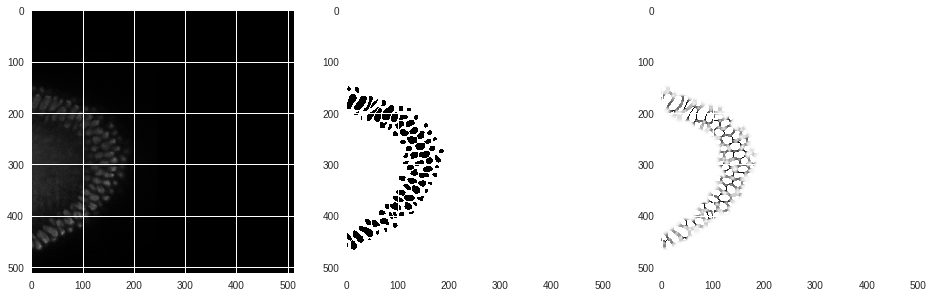

9.899691 1.0 1.1520336


In [100]:
import matplotlib.pyplot as plt
ix_ = np.random.randint(0, len(img_train))

fig = plt.figure(figsize=(16,16))
plt.subplot(1, 3, 1)
plt.imshow(img_train[ix_])
plt.subplot(1, 3, 2)
plt.imshow(gt_train[ix_][...,0])
plt.subplot(1, 3, 3)
plt.imshow(weight_train[ix_][...,0])

plt.show()

print(weight_train[ix_][...,0].max(), weight_train[ix_][...,0].min(), weight_train[ix_][...,0].mean())

In [10]:
import datetime
from keras.optimizers import Adam, SGD

now = datetime.datetime.now()
LOG_DIR = os.path.join(MODEL_DIR, "{}{:%Y%m%dT%H%M}".format(NAME.lower(), now))
checkpoint_path = os.path.join(LOG_DIR, "U_net_{epoch:04d}.h5")

#Model
model = Unet(img_size=420, pad='valid')#crop_size)
model.summary()

#model.compile(optimizer=Adam(lr=0.001), loss=bce_dice_loss, metrics=[mean_iou,KLO.binary_crossentropy])
#model.compile(optimizer=Adam(lr=0.001,clipvalue=5), loss=KLO.binary_crossentropy, metrics=[mean_iou,bce_dice_loss])

# Callbacks
callbacks = [keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=0, write_graph=True, write_images=False),
             keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=0, period=5, save_weights_only=True)
]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 420, 420, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 420, 420, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 418, 418, 32) 896         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 418, 418, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [0]:
model.fit_generator(train_generator, steps_per_epoch=len(img_train)/batch_size, epochs=600,
                    validation_data=val_generator, validation_steps=len(img_val)/batch_size, initial_epoch=0, callbacks=callbacks)

Epoch 1/600
56/55 [==============================] - 98s 2s/step - loss: 0.4386 - mean_iou: 0.2940 - val_loss: 1.1840 - val_mean_iou: 0.3261
Epoch 2/600
56/55 [==============================] - 86s 2s/step - loss: 0.2247 - mean_iou: 0.3231 - val_loss: 0.4009 - val_mean_iou: 0.3192
Epoch 3/600
56/55 [==============================] - 86s 2s/step - loss: 0.1924 - mean_iou: 0.3158 - val_loss: 1.5854 - val_mean_iou: 0.3174
Epoch 4/600
56/55 [==============================] - 86s 2s/step - loss: 0.1634 - mean_iou: 0.3188 - val_loss: 0.7519 - val_mean_iou: 0.3180
Epoch 5/600
44/55 [======================>.......] - ETA: 16s - loss: 0.1312 - mean_iou: 0.3174

56/55 [==============================] - 86s 2s/step - loss: 0.1360 - mean_iou: 0.3178 - val_loss: 0.3336 - val_mean_iou: 0.3178
Epoch 6/600
56/55 [==============================] - 86s 2s/step - loss: 0.1344 - mean_iou: 0.3181 - val_loss: 0.3291 - val_mean_iou: 0.3181
Epoch 7/600
56/55 [==============================] - 86s 2s/step - loss: 0.1340 - mean_iou: 0.3183 - val_loss: 0.3227 - val_mean_iou: 0.3182
Epoch 8/600
56/55 [==============================] - 86s 2s/step - loss: 0.1289 - mean_iou: 0.3185 - val_loss: 0.3279 - val_mean_iou: 0.3181
Epoch 9/600
55/55 [============================>.] - ETA: 0s - loss: 0.1258 - mean_iou: 0.3177

56/55 [==============================] - 86s 2s/step - loss: 0.1255 - mean_iou: 0.3177 - val_loss: 0.2912 - val_mean_iou: 0.3172
Epoch 10/600
56/55 [==============================] - 86s 2s/step - loss: 0.1233 - mean_iou: 0.3169 - val_loss: 0.3746 - val_mean_iou: 0.3167
Epoch 11/600
56/55 [==============================] - 87s 2s/step - loss: 0.1149 - mean_iou: 0.3162 - val_loss: 0.2916 - val_mean_iou: 0.3160
Epoch 12/600
56/55 [==============================] - 86s 2s/step - loss: 0.1096 - mean_iou: 0.3159 - val_loss: 0.3552 - val_mean_iou: 0.3163
Epoch 13/600
30/55 [===============>..............] - ETA: 36s - loss: 0.1035 - mean_iou: 0.3160

56/55 [==============================] - 86s 2s/step - loss: 0.1063 - mean_iou: 0.3165 - val_loss: 0.2920 - val_mean_iou: 0.3172
Epoch 14/600
56/55 [==============================] - 86s 2s/step - loss: 0.1033 - mean_iou: 0.3176 - val_loss: 0.2767 - val_mean_iou: 0.3183
Epoch 15/600
56/55 [==============================] - 86s 2s/step - loss: 0.1029 - mean_iou: 0.3189 - val_loss: 0.2345 - val_mean_iou: 0.3197
Epoch 16/600
56/55 [==============================] - 86s 2s/step - loss: 0.0986 - mean_iou: 0.3205 - val_loss: 0.2527 - val_mean_iou: 0.3211
Epoch 17/600
52/55 [===========================>..] - ETA: 4s - loss: 0.1033 - mean_iou: 0.3211

56/55 [==============================] - 86s 2s/step - loss: 0.1031 - mean_iou: 0.3212 - val_loss: 0.3323 - val_mean_iou: 0.3216
Epoch 18/600
56/55 [==============================] - 86s 2s/step - loss: 0.1024 - mean_iou: 0.3220 - val_loss: 8.8917 - val_mean_iou: 0.3227
Epoch 19/600
56/55 [==============================] - 86s 2s/step - loss: 0.1189 - mean_iou: 0.3229 - val_loss: 0.3636 - val_mean_iou: 0.3225
Epoch 20/600
56/55 [==============================] - 86s 2s/step - loss: 0.1007 - mean_iou: 0.3225 - val_loss: 0.3832 - val_mean_iou: 0.3228
Epoch 21/600
55/55 [============================>.] - ETA: 0s - loss: 0.0975 - mean_iou: 0.3229

56/55 [==============================] - 86s 2s/step - loss: 0.0970 - mean_iou: 0.3229 - val_loss: 0.3317 - val_mean_iou: 0.3234
Epoch 22/600
56/55 [==============================] - 86s 2s/step - loss: 0.0964 - mean_iou: 0.3236 - val_loss: 0.3015 - val_mean_iou: 0.3238
Epoch 23/600
56/55 [==============================] - 86s 2s/step - loss: 0.0932 - mean_iou: 0.3241 - val_loss: 0.2583 - val_mean_iou: 0.3246
Epoch 24/600
56/55 [==============================] - 86s 2s/step - loss: 0.0901 - mean_iou: 0.3251 - val_loss: 0.2916 - val_mean_iou: 0.3255
Epoch 25/600
30/55 [===============>..............] - ETA: 36s - loss: 0.0934 - mean_iou: 0.3255

56/55 [==============================] - 86s 2s/step - loss: 0.0903 - mean_iou: 0.3258 - val_loss: 0.2939 - val_mean_iou: 0.3261
Epoch 26/600
56/55 [==============================] - 86s 2s/step - loss: 0.0907 - mean_iou: 0.3262 - val_loss: 0.2980 - val_mean_iou: 0.3265
Epoch 27/600
56/55 [==============================] - 86s 2s/step - loss: 0.0926 - mean_iou: 0.3266 - val_loss: 0.5051 - val_mean_iou: 0.3269
Epoch 28/600
56/55 [==============================] - 86s 2s/step - loss: 0.0901 - mean_iou: 0.3274 - val_loss: 0.2460 - val_mean_iou: 0.3278
Epoch 29/600
52/55 [===========================>..] - ETA: 4s - loss: 0.0874 - mean_iou: 0.3282

56/55 [==============================] - 86s 2s/step - loss: 0.0867 - mean_iou: 0.3283 - val_loss: 0.3269 - val_mean_iou: 0.3287
Epoch 30/600
56/55 [==============================] - 86s 2s/step - loss: 0.0880 - mean_iou: 0.3290 - val_loss: 0.2740 - val_mean_iou: 0.3293
Epoch 31/600
56/55 [==============================] - 86s 2s/step - loss: 0.0861 - mean_iou: 0.3296 - val_loss: 0.2979 - val_mean_iou: 0.3300
Epoch 32/600
56/55 [==============================] - 86s 2s/step - loss: 0.0846 - mean_iou: 0.3303 - val_loss: 0.2965 - val_mean_iou: 0.3308
Epoch 33/600
55/55 [============================>.] - ETA: 0s - loss: 0.0827 - mean_iou: 0.3311

56/55 [==============================] - 86s 2s/step - loss: 0.0824 - mean_iou: 0.3311 - val_loss: 0.2956 - val_mean_iou: 0.3316
Epoch 34/600
56/55 [==============================] - 86s 2s/step - loss: 0.0838 - mean_iou: 0.3320 - val_loss: 0.3356 - val_mean_iou: 0.3323
Epoch 35/600
56/55 [==============================] - 86s 2s/step - loss: 0.0829 - mean_iou: 0.3325 - val_loss: 0.3288 - val_mean_iou: 0.3329
Epoch 36/600
56/55 [==============================] - 86s 2s/step - loss: 0.0815 - mean_iou: 0.3331 - val_loss: 0.4053 - val_mean_iou: 0.3335
Epoch 37/600
30/55 [===============>..............] - ETA: 36s - loss: 0.0887 - mean_iou: 0.3335

56/55 [==============================] - 86s 2s/step - loss: 0.0801 - mean_iou: 0.3337 - val_loss: 0.3666 - val_mean_iou: 0.3342
Epoch 38/600
56/55 [==============================] - 86s 2s/step - loss: 0.0817 - mean_iou: 0.3345 - val_loss: 0.3300 - val_mean_iou: 0.3349
Epoch 39/600
56/55 [==============================] - 86s 2s/step - loss: 0.0789 - mean_iou: 0.3353 - val_loss: 0.2518 - val_mean_iou: 0.3357
Epoch 40/600
56/55 [==============================] - 86s 2s/step - loss: 0.0797 - mean_iou: 0.3360 - val_loss: 0.2571 - val_mean_iou: 0.3365
Epoch 41/600
52/55 [===========================>..] - ETA: 4s - loss: 0.0792 - mean_iou: 0.3368

56/55 [==============================] - 86s 2s/step - loss: 0.0807 - mean_iou: 0.3368 - val_loss: 0.2621 - val_mean_iou: 0.3372
Epoch 42/600
56/55 [==============================] - 86s 2s/step - loss: 0.0789 - mean_iou: 0.3375 - val_loss: 0.1896 - val_mean_iou: 0.3379
Epoch 43/600
56/55 [==============================] - 86s 2s/step - loss: 0.0772 - mean_iou: 0.3383 - val_loss: 0.2925 - val_mean_iou: 0.3386
Epoch 44/600
56/55 [==============================] - 86s 2s/step - loss: 0.0764 - mean_iou: 0.3389 - val_loss: 0.2333 - val_mean_iou: 0.3393
Epoch 45/600
55/55 [============================>.] - ETA: 0s - loss: 0.0774 - mean_iou: 0.3396

56/55 [==============================] - 86s 2s/step - loss: 0.0774 - mean_iou: 0.3396 - val_loss: 0.2919 - val_mean_iou: 0.3400
Epoch 46/600
56/55 [==============================] - 86s 2s/step - loss: 0.0751 - mean_iou: 0.3403 - val_loss: 0.2959 - val_mean_iou: 0.3407
Epoch 47/600
56/55 [==============================] - 86s 2s/step - loss: 0.0768 - mean_iou: 0.3411 - val_loss: 0.3232 - val_mean_iou: 0.3414
Epoch 48/600
56/55 [==============================] - 86s 2s/step - loss: 0.0768 - mean_iou: 0.3416 - val_loss: 0.3126 - val_mean_iou: 0.3419
Epoch 49/600
30/55 [===============>..............] - ETA: 36s - loss: 0.0769 - mean_iou: 0.3420

56/55 [==============================] - 86s 2s/step - loss: 0.0766 - mean_iou: 0.3422 - val_loss: 0.3175 - val_mean_iou: 0.3425
Epoch 50/600
56/55 [==============================] - 86s 2s/step - loss: 0.0787 - mean_iou: 0.3427 - val_loss: 0.3196 - val_mean_iou: 0.3430
Epoch 51/600
56/55 [==============================] - 86s 2s/step - loss: 0.0778 - mean_iou: 0.3432 - val_loss: 0.3244 - val_mean_iou: 0.3436
Epoch 52/600
56/55 [==============================] - 86s 2s/step - loss: 0.0747 - mean_iou: 0.3438 - val_loss: 0.4380 - val_mean_iou: 0.3441
Epoch 53/600
52/55 [===========================>..] - ETA: 4s - loss: 0.0777 - mean_iou: 0.3442

56/55 [==============================] - 86s 2s/step - loss: 0.0767 - mean_iou: 0.3443 - val_loss: 0.4037 - val_mean_iou: 0.3445
Epoch 54/600
56/55 [==============================] - 86s 2s/step - loss: 0.0762 - mean_iou: 0.3447 - val_loss: 0.4400 - val_mean_iou: 0.3449
Epoch 55/600
56/55 [==============================] - 86s 2s/step - loss: 0.0742 - mean_iou: 0.3451 - val_loss: 0.3537 - val_mean_iou: 0.3454
Epoch 56/600
56/55 [==============================] - 86s 2s/step - loss: 0.0750 - mean_iou: 0.3457 - val_loss: 0.2801 - val_mean_iou: 0.3460
Epoch 57/600
55/55 [============================>.] - ETA: 0s - loss: 0.0752 - mean_iou: 0.3462

56/55 [==============================] - 86s 2s/step - loss: 0.0759 - mean_iou: 0.3462 - val_loss: 0.3259 - val_mean_iou: 0.3465
Epoch 58/600
56/55 [==============================] - 86s 2s/step - loss: 0.0763 - mean_iou: 0.3467 - val_loss: 0.2967 - val_mean_iou: 0.3469
Epoch 59/600
56/55 [==============================] - 86s 2s/step - loss: 0.0705 - mean_iou: 0.3472 - val_loss: 0.2549 - val_mean_iou: 0.3475
Epoch 60/600
56/55 [==============================] - 86s 2s/step - loss: 0.0726 - mean_iou: 0.3478 - val_loss: 0.4603 - val_mean_iou: 0.3480
Epoch 61/600
30/55 [===============>..............] - ETA: 36s - loss: 0.0668 - mean_iou: 0.3481

56/55 [==============================] - 86s 2s/step - loss: 0.0712 - mean_iou: 0.3483 - val_loss: 0.3755 - val_mean_iou: 0.3485
Epoch 62/600
56/55 [==============================] - 86s 2s/step - loss: 0.0701 - mean_iou: 0.3488 - val_loss: 0.3648 - val_mean_iou: 0.3490
Epoch 63/600
56/55 [==============================] - 85s 2s/step - loss: 0.0729 - mean_iou: 0.3493 - val_loss: 0.3684 - val_mean_iou: 0.3495
Epoch 64/600
56/55 [==============================] - 86s 2s/step - loss: 0.0720 - mean_iou: 0.3497 - val_loss: 0.3461 - val_mean_iou: 0.3500
Epoch 65/600
52/55 [===========================>..] - ETA: 4s - loss: 0.0730 - mean_iou: 0.3502

56/55 [==============================] - 86s 2s/step - loss: 0.0721 - mean_iou: 0.3502 - val_loss: 0.3166 - val_mean_iou: 0.3503
Epoch 66/600
56/55 [==============================] - 86s 2s/step - loss: 0.0713 - mean_iou: 0.3504 - val_loss: 0.3898 - val_mean_iou: 0.3506
Epoch 67/600
56/55 [==============================] - 86s 2s/step - loss: 0.0696 - mean_iou: 0.3507 - val_loss: 0.2919 - val_mean_iou: 0.3509
Epoch 68/600
56/55 [==============================] - 86s 2s/step - loss: 0.0700 - mean_iou: 0.3512 - val_loss: 0.3339 - val_mean_iou: 0.3514
Epoch 69/600
55/55 [============================>.] - ETA: 0s - loss: 0.0720 - mean_iou: 0.3516

56/55 [==============================] - 86s 2s/step - loss: 0.0719 - mean_iou: 0.3516 - val_loss: 0.3271 - val_mean_iou: 0.3518
Epoch 70/600
56/55 [==============================] - 86s 2s/step - loss: 0.0699 - mean_iou: 0.3519 - val_loss: 0.4369 - val_mean_iou: 0.3521
Epoch 71/600
56/55 [==============================] - 86s 2s/step - loss: 0.0691 - mean_iou: 0.3523 - val_loss: 0.3940 - val_mean_iou: 0.3525
Epoch 72/600
56/55 [==============================] - 86s 2s/step - loss: 0.0695 - mean_iou: 0.3527 - val_loss: 0.2559 - val_mean_iou: 0.3529
Epoch 73/600
30/55 [===============>..............] - ETA: 36s - loss: 0.0630 - mean_iou: 0.3530

56/55 [==============================] - 86s 2s/step - loss: 0.0688 - mean_iou: 0.3531 - val_loss: 0.2323 - val_mean_iou: 0.3533
Epoch 74/600
56/55 [==============================] - 86s 2s/step - loss: 0.0694 - mean_iou: 0.3535 - val_loss: 0.3523 - val_mean_iou: 0.3536
Epoch 75/600
56/55 [==============================] - 86s 2s/step - loss: 0.0686 - mean_iou: 0.3537 - val_loss: 0.3385 - val_mean_iou: 0.3539
Epoch 76/600
56/55 [==============================] - 87s 2s/step - loss: 0.0679 - mean_iou: 0.3541 - val_loss: 0.4161 - val_mean_iou: 0.3542
Epoch 77/600
52/55 [===========================>..] - ETA: 4s - loss: 0.0711 - mean_iou: 0.3544

56/55 [==============================] - 86s 2s/step - loss: 0.0697 - mean_iou: 0.3544 - val_loss: 0.3454 - val_mean_iou: 0.3546
Epoch 78/600
56/55 [==============================] - 86s 2s/step - loss: 0.0674 - mean_iou: 0.3547 - val_loss: 0.2889 - val_mean_iou: 0.3549
Epoch 79/600
56/55 [==============================] - 86s 2s/step - loss: 0.0706 - mean_iou: 0.3550 - val_loss: 0.2796 - val_mean_iou: 0.3551
Epoch 80/600
56/55 [==============================] - 87s 2s/step - loss: 0.0686 - mean_iou: 0.3553 - val_loss: 0.3793 - val_mean_iou: 0.3554
Epoch 81/600
55/55 [============================>.] - ETA: 0s - loss: 0.0770 - mean_iou: 0.3554

56/55 [==============================] - 86s 2s/step - loss: 0.0769 - mean_iou: 0.3554 - val_loss: 0.4871 - val_mean_iou: 0.3554
Epoch 82/600
56/55 [==============================] - 86s 2s/step - loss: 0.0750 - mean_iou: 0.3554 - val_loss: 0.2735 - val_mean_iou: 0.3555
Epoch 83/600
56/55 [==============================] - 86s 2s/step - loss: 0.0690 - mean_iou: 0.3556 - val_loss: 0.3427 - val_mean_iou: 0.3558
Epoch 84/600
56/55 [==============================] - 86s 2s/step - loss: 0.0673 - mean_iou: 0.3559 - val_loss: 0.3718 - val_mean_iou: 0.3561
Epoch 85/600
30/55 [===============>..............] - ETA: 36s - loss: 0.0672 - mean_iou: 0.3562

56/55 [==============================] - 86s 2s/step - loss: 0.0679 - mean_iou: 0.3562 - val_loss: 0.3320 - val_mean_iou: 0.3564
Epoch 86/600
56/55 [==============================] - 87s 2s/step - loss: 0.0679 - mean_iou: 0.3565 - val_loss: 0.3635 - val_mean_iou: 0.3567
Epoch 87/600
56/55 [==============================] - 86s 2s/step - loss: 0.0681 - mean_iou: 0.3568 - val_loss: 0.4349 - val_mean_iou: 0.3570
Epoch 88/600
56/55 [==============================] - 86s 2s/step - loss: 0.0655 - mean_iou: 0.3571 - val_loss: 0.4226 - val_mean_iou: 0.3573
Epoch 89/600
52/55 [===========================>..] - ETA: 4s - loss: 0.0684 - mean_iou: 0.3573

56/55 [==============================] - 86s 2s/step - loss: 0.0682 - mean_iou: 0.3573 - val_loss: 0.3927 - val_mean_iou: 0.3575
Epoch 90/600
56/55 [==============================] - 86s 2s/step - loss: 0.0674 - mean_iou: 0.3576 - val_loss: 0.3105 - val_mean_iou: 0.3578
Epoch 91/600
56/55 [==============================] - 86s 2s/step - loss: 0.0677 - mean_iou: 0.3579 - val_loss: 0.3985 - val_mean_iou: 0.3580
Epoch 92/600
56/55 [==============================] - 86s 2s/step - loss: 0.0659 - mean_iou: 0.3581 - val_loss: 0.3667 - val_mean_iou: 0.3583
Epoch 93/600
55/55 [============================>.] - ETA: 0s - loss: 0.0668 - mean_iou: 0.3584

56/55 [==============================] - 86s 2s/step - loss: 0.0667 - mean_iou: 0.3584 - val_loss: 0.2602 - val_mean_iou: 0.3586
Epoch 94/600
56/55 [==============================] - 86s 2s/step - loss: 0.0668 - mean_iou: 0.3587 - val_loss: 0.4075 - val_mean_iou: 0.3588
Epoch 95/600
56/55 [==============================] - 86s 2s/step - loss: 0.0688 - mean_iou: 0.3589 - val_loss: 0.3225 - val_mean_iou: 0.3591
Epoch 96/600
56/55 [==============================] - 86s 2s/step - loss: 0.0649 - mean_iou: 0.3592 - val_loss: 0.3190 - val_mean_iou: 0.3593
Epoch 97/600
30/55 [===============>..............] - ETA: 36s - loss: 0.0695 - mean_iou: 0.3594

56/55 [==============================] - 86s 2s/step - loss: 0.0656 - mean_iou: 0.3595 - val_loss: 0.3270 - val_mean_iou: 0.3596
Epoch 98/600
56/55 [==============================] - 86s 2s/step - loss: 0.0646 - mean_iou: 0.3597 - val_loss: 0.2820 - val_mean_iou: 0.3599
Epoch 99/600
56/55 [==============================] - 86s 2s/step - loss: 0.0653 - mean_iou: 0.3600 - val_loss: 0.2856 - val_mean_iou: 0.3601
Epoch 100/600
56/55 [==============================] - 86s 2s/step - loss: 0.0649 - mean_iou: 0.3602 - val_loss: 0.4452 - val_mean_iou: 0.3604
Epoch 101/600
52/55 [===========================>..] - ETA: 4s - loss: 0.0653 - mean_iou: 0.3604

56/55 [==============================] - 86s 2s/step - loss: 0.0651 - mean_iou: 0.3604 - val_loss: 0.4100 - val_mean_iou: 0.3606
Epoch 102/600
56/55 [==============================] - 86s 2s/step - loss: 0.0642 - mean_iou: 0.3607 - val_loss: 0.2722 - val_mean_iou: 0.3609
Epoch 103/600
56/55 [==============================] - 86s 2s/step - loss: 0.0685 - mean_iou: 0.3610 - val_loss: 0.4012 - val_mean_iou: 0.3611
Epoch 104/600
56/55 [==============================] - 86s 2s/step - loss: 0.0676 - mean_iou: 0.3612 - val_loss: 0.3278 - val_mean_iou: 0.3613
Epoch 105/600
54/55 [============================>.] - ETA: 1s - loss: 0.0669 - mean_iou: 0.3614

56/55 [==============================] - 86s 2s/step - loss: 0.0665 - mean_iou: 0.3614 - val_loss: 0.3662 - val_mean_iou: 0.3615
Epoch 106/600
56/55 [==============================] - 86s 2s/step - loss: 0.0661 - mean_iou: 0.3616 - val_loss: 0.2369 - val_mean_iou: 0.3617
Epoch 107/600
56/55 [==============================] - 86s 2s/step - loss: 0.0650 - mean_iou: 0.3618 - val_loss: 0.2967 - val_mean_iou: 0.3620
Epoch 108/600
56/55 [==============================] - 86s 2s/step - loss: 0.0639 - mean_iou: 0.3621 - val_loss: 0.2782 - val_mean_iou: 0.3622
Epoch 109/600
55/55 [============================>.] - ETA: 0s - loss: 0.0638 - mean_iou: 0.3623

56/55 [==============================] - 86s 2s/step - loss: 0.0636 - mean_iou: 0.3623 - val_loss: 0.3736 - val_mean_iou: 0.3624
Epoch 110/600
56/55 [==============================] - 86s 2s/step - loss: 0.0644 - mean_iou: 0.3626 - val_loss: 0.3721 - val_mean_iou: 0.3627
Epoch 111/600
56/55 [==============================] - 86s 2s/step - loss: 0.0632 - mean_iou: 0.3628 - val_loss: 0.3511 - val_mean_iou: 0.3629
Epoch 112/600
56/55 [==============================] - 86s 2s/step - loss: 0.0635 - mean_iou: 0.3630 - val_loss: 0.3186 - val_mean_iou: 0.3631
Epoch 113/600
29/55 [==============>...............] - ETA: 38s - loss: 0.0651 - mean_iou: 0.3631

56/55 [==============================] - 86s 2s/step - loss: 0.0650 - mean_iou: 0.3632 - val_loss: 0.2286 - val_mean_iou: 0.3633
Epoch 114/600
56/55 [==============================] - 86s 2s/step - loss: 0.0642 - mean_iou: 0.3634 - val_loss: 0.3285 - val_mean_iou: 0.3635
Epoch 115/600
56/55 [==============================] - 86s 2s/step - loss: 0.0646 - mean_iou: 0.3636 - val_loss: 0.3365 - val_mean_iou: 0.3637
Epoch 116/600
56/55 [==============================] - 86s 2s/step - loss: 0.0640 - mean_iou: 0.3638 - val_loss: 0.4488 - val_mean_iou: 0.3639
Epoch 117/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0634 - mean_iou: 0.3640

56/55 [==============================] - 86s 2s/step - loss: 0.0627 - mean_iou: 0.3640 - val_loss: 0.3417 - val_mean_iou: 0.3641
Epoch 118/600
56/55 [==============================] - 86s 2s/step - loss: 0.0646 - mean_iou: 0.3642 - val_loss: 0.3925 - val_mean_iou: 0.3643
Epoch 119/600
56/55 [==============================] - 86s 2s/step - loss: 0.0617 - mean_iou: 0.3644 - val_loss: 0.3491 - val_mean_iou: 0.3645
Epoch 120/600
56/55 [==============================] - 86s 2s/step - loss: 0.0643 - mean_iou: 0.3646 - val_loss: 0.3856 - val_mean_iou: 0.3647
Epoch 121/600
54/55 [============================>.] - ETA: 1s - loss: 0.0624 - mean_iou: 0.3648

56/55 [==============================] - 86s 2s/step - loss: 0.0634 - mean_iou: 0.3648 - val_loss: 0.4124 - val_mean_iou: 0.3649
Epoch 122/600
56/55 [==============================] - 87s 2s/step - loss: 0.0634 - mean_iou: 0.3650 - val_loss: 0.4066 - val_mean_iou: 0.3651
Epoch 123/600
56/55 [==============================] - 86s 2s/step - loss: 0.0653 - mean_iou: 0.3652 - val_loss: 0.3278 - val_mean_iou: 0.3653
Epoch 124/600
56/55 [==============================] - 87s 2s/step - loss: 0.0638 - mean_iou: 0.3654 - val_loss: 0.3775 - val_mean_iou: 0.3655
Epoch 125/600
55/55 [============================>.] - ETA: 0s - loss: 0.0642 - mean_iou: 0.3656

56/55 [==============================] - 86s 2s/step - loss: 0.0636 - mean_iou: 0.3656 - val_loss: 0.3433 - val_mean_iou: 0.3657
Epoch 126/600
56/55 [==============================] - 86s 2s/step - loss: 0.0624 - mean_iou: 0.3658 - val_loss: 0.4671 - val_mean_iou: 0.3659
Epoch 127/600
56/55 [==============================] - 86s 2s/step - loss: 0.0615 - mean_iou: 0.3660 - val_loss: 0.3873 - val_mean_iou: 0.3661
Epoch 128/600
56/55 [==============================] - 86s 2s/step - loss: 0.0637 - mean_iou: 0.3662 - val_loss: 0.4336 - val_mean_iou: 0.3663
Epoch 129/600
29/55 [==============>...............] - ETA: 38s - loss: 0.0586 - mean_iou: 0.3663

56/55 [==============================] - 86s 2s/step - loss: 0.0636 - mean_iou: 0.3664 - val_loss: 0.3320 - val_mean_iou: 0.3665
Epoch 130/600
56/55 [==============================] - 86s 2s/step - loss: 0.0618 - mean_iou: 0.3665 - val_loss: 0.2622 - val_mean_iou: 0.3666
Epoch 131/600
56/55 [==============================] - 86s 2s/step - loss: 0.0621 - mean_iou: 0.3667 - val_loss: 0.3286 - val_mean_iou: 0.3669
Epoch 132/600
56/55 [==============================] - 86s 2s/step - loss: 0.0642 - mean_iou: 0.3669 - val_loss: 0.2751 - val_mean_iou: 0.3670
Epoch 133/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0601 - mean_iou: 0.3671

56/55 [==============================] - 86s 2s/step - loss: 0.0609 - mean_iou: 0.3671 - val_loss: 0.3999 - val_mean_iou: 0.3672
Epoch 134/600
56/55 [==============================] - 86s 2s/step - loss: 0.0612 - mean_iou: 0.3673 - val_loss: 0.3259 - val_mean_iou: 0.3674
Epoch 135/600
56/55 [==============================] - 86s 2s/step - loss: 0.0606 - mean_iou: 0.3674 - val_loss: 0.3590 - val_mean_iou: 0.3675
Epoch 136/600
56/55 [==============================] - 86s 2s/step - loss: 0.0632 - mean_iou: 0.3676 - val_loss: 0.3184 - val_mean_iou: 0.3676
Epoch 137/600
54/55 [============================>.] - ETA: 1s - loss: 0.0608 - mean_iou: 0.3676

56/55 [==============================] - 86s 2s/step - loss: 0.0604 - mean_iou: 0.3677 - val_loss: 0.3428 - val_mean_iou: 0.3677
Epoch 138/600
56/55 [==============================] - 86s 2s/step - loss: 0.0611 - mean_iou: 0.3678 - val_loss: 0.3864 - val_mean_iou: 0.3679
Epoch 139/600
56/55 [==============================] - 87s 2s/step - loss: 0.0614 - mean_iou: 0.3680 - val_loss: 0.4012 - val_mean_iou: 0.3680
Epoch 140/600
56/55 [==============================] - 86s 2s/step - loss: 0.0632 - mean_iou: 0.3681 - val_loss: 0.3380 - val_mean_iou: 0.3682
Epoch 141/600
55/55 [============================>.] - ETA: 0s - loss: 0.0641 - mean_iou: 0.3682

56/55 [==============================] - 86s 2s/step - loss: 0.0638 - mean_iou: 0.3682 - val_loss: 0.3113 - val_mean_iou: 0.3683
Epoch 142/600
56/55 [==============================] - 86s 2s/step - loss: 0.0614 - mean_iou: 0.3684 - val_loss: 0.3597 - val_mean_iou: 0.3685
Epoch 143/600
56/55 [==============================] - 86s 2s/step - loss: 0.0627 - mean_iou: 0.3686 - val_loss: 0.2721 - val_mean_iou: 0.3686
Epoch 144/600
56/55 [==============================] - 86s 2s/step - loss: 0.0621 - mean_iou: 0.3687 - val_loss: 0.2607 - val_mean_iou: 0.3688
Epoch 145/600
29/55 [==============>...............] - ETA: 38s - loss: 0.0577 - mean_iou: 0.3688

56/55 [==============================] - 86s 2s/step - loss: 0.0595 - mean_iou: 0.3689 - val_loss: 0.2892 - val_mean_iou: 0.3690
Epoch 146/600
56/55 [==============================] - 86s 2s/step - loss: 0.0590 - mean_iou: 0.3691 - val_loss: 0.3698 - val_mean_iou: 0.3691
Epoch 147/600
56/55 [==============================] - 86s 2s/step - loss: 0.0605 - mean_iou: 0.3692 - val_loss: 0.3764 - val_mean_iou: 0.3693
Epoch 148/600
56/55 [==============================] - 86s 2s/step - loss: 0.0606 - mean_iou: 0.3694 - val_loss: 0.2380 - val_mean_iou: 0.3695
Epoch 149/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0622 - mean_iou: 0.3696

56/55 [==============================] - 86s 2s/step - loss: 0.0607 - mean_iou: 0.3696 - val_loss: 0.3993 - val_mean_iou: 0.3696
Epoch 150/600
56/55 [==============================] - 87s 2s/step - loss: 0.0601 - mean_iou: 0.3697 - val_loss: 0.4164 - val_mean_iou: 0.3698
Epoch 151/600
56/55 [==============================] - 86s 2s/step - loss: 0.0596 - mean_iou: 0.3699 - val_loss: 0.3744 - val_mean_iou: 0.3700
Epoch 152/600
56/55 [==============================] - 86s 2s/step - loss: 0.0619 - mean_iou: 0.3700 - val_loss: 0.4425 - val_mean_iou: 0.3701
Epoch 153/600
54/55 [============================>.] - ETA: 1s - loss: 0.0617 - mean_iou: 0.3702

56/55 [==============================] - 86s 2s/step - loss: 0.0613 - mean_iou: 0.3702 - val_loss: 0.4141 - val_mean_iou: 0.3702
Epoch 154/600
56/55 [==============================] - 86s 2s/step - loss: 0.0611 - mean_iou: 0.3703 - val_loss: 0.4346 - val_mean_iou: 0.3704
Epoch 155/600
56/55 [==============================] - 86s 2s/step - loss: 0.0598 - mean_iou: 0.3704 - val_loss: 0.3435 - val_mean_iou: 0.3705
Epoch 156/600
56/55 [==============================] - 86s 2s/step - loss: 0.0594 - mean_iou: 0.3706 - val_loss: 0.3664 - val_mean_iou: 0.3706
Epoch 157/600
55/55 [============================>.] - ETA: 0s - loss: 0.0629 - mean_iou: 0.3707

56/55 [==============================] - 86s 2s/step - loss: 0.0632 - mean_iou: 0.3707 - val_loss: 0.5016 - val_mean_iou: 0.3708
Epoch 158/600
56/55 [==============================] - 86s 2s/step - loss: 0.0612 - mean_iou: 0.3708 - val_loss: 0.3851 - val_mean_iou: 0.3709
Epoch 159/600
56/55 [==============================] - 86s 2s/step - loss: 0.0595 - mean_iou: 0.3709 - val_loss: 0.2936 - val_mean_iou: 0.3710
Epoch 160/600
56/55 [==============================] - 86s 2s/step - loss: 0.0592 - mean_iou: 0.3711 - val_loss: 0.4365 - val_mean_iou: 0.3712
Epoch 161/600
29/55 [==============>...............] - ETA: 38s - loss: 0.0645 - mean_iou: 0.3712

56/55 [==============================] - 86s 2s/step - loss: 0.0593 - mean_iou: 0.3712 - val_loss: 0.3033 - val_mean_iou: 0.3713
Epoch 162/600
56/55 [==============================] - 86s 2s/step - loss: 0.0580 - mean_iou: 0.3713 - val_loss: 0.3913 - val_mean_iou: 0.3714
Epoch 163/600
56/55 [==============================] - 86s 2s/step - loss: 0.0592 - mean_iou: 0.3715 - val_loss: 0.4459 - val_mean_iou: 0.3716
Epoch 164/600
56/55 [==============================] - 86s 2s/step - loss: 0.0602 - mean_iou: 0.3716 - val_loss: 0.4865 - val_mean_iou: 0.3717
Epoch 165/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0601 - mean_iou: 0.3717

56/55 [==============================] - 86s 2s/step - loss: 0.0606 - mean_iou: 0.3717 - val_loss: 0.3363 - val_mean_iou: 0.3718
Epoch 166/600
56/55 [==============================] - 86s 2s/step - loss: 0.0605 - mean_iou: 0.3718 - val_loss: 0.4463 - val_mean_iou: 0.3719
Epoch 167/600
56/55 [==============================] - 86s 2s/step - loss: 0.0611 - mean_iou: 0.3719 - val_loss: 0.3494 - val_mean_iou: 0.3720
Epoch 168/600
56/55 [==============================] - 86s 2s/step - loss: 0.0585 - mean_iou: 0.3720 - val_loss: 0.4336 - val_mean_iou: 0.3721
Epoch 169/600
54/55 [============================>.] - ETA: 1s - loss: 0.0606 - mean_iou: 0.3722

56/55 [==============================] - 86s 2s/step - loss: 0.0609 - mean_iou: 0.3722 - val_loss: 0.3597 - val_mean_iou: 0.3722
Epoch 170/600
56/55 [==============================] - 86s 2s/step - loss: 0.0588 - mean_iou: 0.3723 - val_loss: 0.3497 - val_mean_iou: 0.3724
Epoch 171/600
56/55 [==============================] - 86s 2s/step - loss: 0.0602 - mean_iou: 0.3724 - val_loss: 0.3602 - val_mean_iou: 0.3725
Epoch 172/600
56/55 [==============================] - 86s 2s/step - loss: 0.0609 - mean_iou: 0.3725 - val_loss: 0.2797 - val_mean_iou: 0.3726
Epoch 173/600
55/55 [============================>.] - ETA: 0s - loss: 0.0598 - mean_iou: 0.3726

56/55 [==============================] - 86s 2s/step - loss: 0.0598 - mean_iou: 0.3726 - val_loss: 0.4149 - val_mean_iou: 0.3727
Epoch 174/600
56/55 [==============================] - 86s 2s/step - loss: 0.0600 - mean_iou: 0.3727 - val_loss: 0.5214 - val_mean_iou: 0.3728
Epoch 175/600
56/55 [==============================] - 86s 2s/step - loss: 0.0585 - mean_iou: 0.3728 - val_loss: 0.3288 - val_mean_iou: 0.3729
Epoch 176/600
56/55 [==============================] - 86s 2s/step - loss: 0.0590 - mean_iou: 0.3730 - val_loss: 0.3997 - val_mean_iou: 0.3730
Epoch 177/600
29/55 [==============>...............] - ETA: 37s - loss: 0.0594 - mean_iou: 0.3730

56/55 [==============================] - 86s 2s/step - loss: 0.0578 - mean_iou: 0.3731 - val_loss: 0.4245 - val_mean_iou: 0.3731
Epoch 178/600
56/55 [==============================] - 86s 2s/step - loss: 0.0595 - mean_iou: 0.3732 - val_loss: 0.4311 - val_mean_iou: 0.3732
Epoch 179/600
56/55 [==============================] - 86s 2s/step - loss: 0.0584 - mean_iou: 0.3733 - val_loss: 0.4614 - val_mean_iou: 0.3733
Epoch 180/600
56/55 [==============================] - 86s 2s/step - loss: 0.0589 - mean_iou: 0.3734 - val_loss: 0.4001 - val_mean_iou: 0.3734
Epoch 181/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0590 - mean_iou: 0.3735

56/55 [==============================] - 86s 2s/step - loss: 0.0593 - mean_iou: 0.3735 - val_loss: 0.3789 - val_mean_iou: 0.3735
Epoch 182/600
56/55 [==============================] - 86s 2s/step - loss: 0.0589 - mean_iou: 0.3736 - val_loss: 0.3765 - val_mean_iou: 0.3736
Epoch 183/600
56/55 [==============================] - 86s 2s/step - loss: 0.0596 - mean_iou: 0.3737 - val_loss: 0.4160 - val_mean_iou: 0.3737
Epoch 184/600
56/55 [==============================] - 86s 2s/step - loss: 0.0592 - mean_iou: 0.3738 - val_loss: 0.4174 - val_mean_iou: 0.3738
Epoch 185/600
54/55 [============================>.] - ETA: 1s - loss: 0.0586 - mean_iou: 0.3739

56/55 [==============================] - 86s 2s/step - loss: 0.0586 - mean_iou: 0.3739 - val_loss: 0.4010 - val_mean_iou: 0.3740
Epoch 186/600
56/55 [==============================] - 86s 2s/step - loss: 0.0586 - mean_iou: 0.3740 - val_loss: 0.4118 - val_mean_iou: 0.3741
Epoch 187/600
56/55 [==============================] - 86s 2s/step - loss: 0.0580 - mean_iou: 0.3741 - val_loss: 0.2964 - val_mean_iou: 0.3742
Epoch 188/600
56/55 [==============================] - 86s 2s/step - loss: 0.0579 - mean_iou: 0.3743 - val_loss: 0.3775 - val_mean_iou: 0.3743
Epoch 189/600
55/55 [============================>.] - ETA: 0s - loss: 0.0581 - mean_iou: 0.3744

56/55 [==============================] - 86s 2s/step - loss: 0.0578 - mean_iou: 0.3744 - val_loss: 0.4672 - val_mean_iou: 0.3744
Epoch 190/600
56/55 [==============================] - 86s 2s/step - loss: 0.0590 - mean_iou: 0.3745 - val_loss: 0.3965 - val_mean_iou: 0.3745
Epoch 191/600
56/55 [==============================] - 86s 2s/step - loss: 0.0583 - mean_iou: 0.3746 - val_loss: 0.4024 - val_mean_iou: 0.3746
Epoch 192/600
56/55 [==============================] - 86s 2s/step - loss: 0.0608 - mean_iou: 0.3747 - val_loss: 0.3184 - val_mean_iou: 0.3747
Epoch 193/600
29/55 [==============>...............] - ETA: 38s - loss: 0.0524 - mean_iou: 0.3748

56/55 [==============================] - 86s 2s/step - loss: 0.0576 - mean_iou: 0.3748 - val_loss: 0.4193 - val_mean_iou: 0.3748
Epoch 194/600
56/55 [==============================] - 86s 2s/step - loss: 0.0597 - mean_iou: 0.3749 - val_loss: 0.4112 - val_mean_iou: 0.3749
Epoch 195/600
56/55 [==============================] - 86s 2s/step - loss: 0.0587 - mean_iou: 0.3750 - val_loss: 0.4566 - val_mean_iou: 0.3750
Epoch 196/600
56/55 [==============================] - 86s 2s/step - loss: 0.0574 - mean_iou: 0.3751 - val_loss: 0.4571 - val_mean_iou: 0.3751
Epoch 197/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0583 - mean_iou: 0.3752

56/55 [==============================] - 86s 2s/step - loss: 0.0586 - mean_iou: 0.3752 - val_loss: 0.3363 - val_mean_iou: 0.3752
Epoch 198/600
56/55 [==============================] - 86s 2s/step - loss: 0.0588 - mean_iou: 0.3753 - val_loss: 0.4424 - val_mean_iou: 0.3753
Epoch 199/600
56/55 [==============================] - 86s 2s/step - loss: 0.0586 - mean_iou: 0.3754 - val_loss: 0.2800 - val_mean_iou: 0.3754
Epoch 200/600
56/55 [==============================] - 86s 2s/step - loss: 0.0572 - mean_iou: 0.3755 - val_loss: 0.3969 - val_mean_iou: 0.3755
Epoch 201/600
54/55 [============================>.] - ETA: 1s - loss: 0.0561 - mean_iou: 0.3756

56/55 [==============================] - 86s 2s/step - loss: 0.0558 - mean_iou: 0.3756 - val_loss: 0.3705 - val_mean_iou: 0.3756
Epoch 202/600
56/55 [==============================] - 86s 2s/step - loss: 0.0564 - mean_iou: 0.3757 - val_loss: 0.4117 - val_mean_iou: 0.3758
Epoch 203/600
56/55 [==============================] - 86s 2s/step - loss: 0.0581 - mean_iou: 0.3758 - val_loss: 0.4398 - val_mean_iou: 0.3758
Epoch 204/600
56/55 [==============================] - 86s 2s/step - loss: 0.0594 - mean_iou: 0.3759 - val_loss: 0.3735 - val_mean_iou: 0.3759
Epoch 205/600
55/55 [============================>.] - ETA: 0s - loss: 0.0591 - mean_iou: 0.3759

56/55 [==============================] - 86s 2s/step - loss: 0.0587 - mean_iou: 0.3759 - val_loss: 0.3474 - val_mean_iou: 0.3760
Epoch 206/600
56/55 [==============================] - 86s 2s/step - loss: 0.0603 - mean_iou: 0.3760 - val_loss: 0.4205 - val_mean_iou: 0.3761
Epoch 207/600
56/55 [==============================] - 86s 2s/step - loss: 0.0605 - mean_iou: 0.3761 - val_loss: 0.3779 - val_mean_iou: 0.3762
Epoch 208/600
56/55 [==============================] - 86s 2s/step - loss: 0.0581 - mean_iou: 0.3762 - val_loss: 0.5074 - val_mean_iou: 0.3763
Epoch 209/600
29/55 [==============>...............] - ETA: 37s - loss: 0.0550 - mean_iou: 0.3763

56/55 [==============================] - 86s 2s/step - loss: 0.0573 - mean_iou: 0.3763 - val_loss: 0.4060 - val_mean_iou: 0.3763
Epoch 210/600
56/55 [==============================] - 86s 2s/step - loss: 0.0575 - mean_iou: 0.3764 - val_loss: 0.4025 - val_mean_iou: 0.3764
Epoch 211/600
56/55 [==============================] - 86s 2s/step - loss: 0.0575 - mean_iou: 0.3765 - val_loss: 0.3477 - val_mean_iou: 0.3765
Epoch 212/600
56/55 [==============================] - 86s 2s/step - loss: 0.0567 - mean_iou: 0.3766 - val_loss: 0.4148 - val_mean_iou: 0.3766
Epoch 213/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0591 - mean_iou: 0.3767

56/55 [==============================] - 86s 2s/step - loss: 0.0583 - mean_iou: 0.3767 - val_loss: 0.3941 - val_mean_iou: 0.3767
Epoch 214/600
56/55 [==============================] - 86s 2s/step - loss: 0.0572 - mean_iou: 0.3768 - val_loss: 0.4507 - val_mean_iou: 0.3768
Epoch 215/600
56/55 [==============================] - 86s 2s/step - loss: 0.0573 - mean_iou: 0.3769 - val_loss: 0.4782 - val_mean_iou: 0.3769
Epoch 216/600
56/55 [==============================] - 86s 2s/step - loss: 0.0571 - mean_iou: 0.3769 - val_loss: 0.3694 - val_mean_iou: 0.3770
Epoch 217/600
54/55 [============================>.] - ETA: 1s - loss: 0.0567 - mean_iou: 0.3770

56/55 [==============================] - 86s 2s/step - loss: 0.0566 - mean_iou: 0.3770 - val_loss: 0.3320 - val_mean_iou: 0.3771
Epoch 218/600
56/55 [==============================] - 86s 2s/step - loss: 0.0577 - mean_iou: 0.3771 - val_loss: 0.3601 - val_mean_iou: 0.3772
Epoch 219/600
56/55 [==============================] - 86s 2s/step - loss: 0.0568 - mean_iou: 0.3772 - val_loss: 0.4679 - val_mean_iou: 0.3773
Epoch 220/600
56/55 [==============================] - 86s 2s/step - loss: 0.0570 - mean_iou: 0.3773 - val_loss: 0.5069 - val_mean_iou: 0.3774
Epoch 221/600
55/55 [============================>.] - ETA: 0s - loss: 0.0553 - mean_iou: 0.3774

56/55 [==============================] - 86s 2s/step - loss: 0.0553 - mean_iou: 0.3774 - val_loss: 0.4155 - val_mean_iou: 0.3774
Epoch 222/600
56/55 [==============================] - 86s 2s/step - loss: 0.0568 - mean_iou: 0.3775 - val_loss: 0.4558 - val_mean_iou: 0.3775
Epoch 223/600
56/55 [==============================] - 86s 2s/step - loss: 0.0581 - mean_iou: 0.3776 - val_loss: 0.3811 - val_mean_iou: 0.3776
Epoch 224/600
56/55 [==============================] - 86s 2s/step - loss: 0.0569 - mean_iou: 0.3776 - val_loss: 0.3822 - val_mean_iou: 0.3777
Epoch 225/600
29/55 [==============>...............] - ETA: 38s - loss: 0.0602 - mean_iou: 0.3777

56/55 [==============================] - 86s 2s/step - loss: 0.0557 - mean_iou: 0.3777 - val_loss: 0.5399 - val_mean_iou: 0.3778
Epoch 226/600
56/55 [==============================] - 86s 2s/step - loss: 0.0567 - mean_iou: 0.3778 - val_loss: 0.4596 - val_mean_iou: 0.3778
Epoch 227/600
56/55 [==============================] - 86s 2s/step - loss: 0.0578 - mean_iou: 0.3779 - val_loss: 0.3805 - val_mean_iou: 0.3779
Epoch 228/600
56/55 [==============================] - 87s 2s/step - loss: 0.0565 - mean_iou: 0.3780 - val_loss: 0.4932 - val_mean_iou: 0.3780
Epoch 229/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0553 - mean_iou: 0.3781

56/55 [==============================] - 86s 2s/step - loss: 0.0556 - mean_iou: 0.3781 - val_loss: 0.4108 - val_mean_iou: 0.3781
Epoch 230/600
56/55 [==============================] - 86s 2s/step - loss: 0.0569 - mean_iou: 0.3782 - val_loss: 0.6062 - val_mean_iou: 0.3782
Epoch 231/600
56/55 [==============================] - 86s 2s/step - loss: 0.0573 - mean_iou: 0.3782 - val_loss: 0.4666 - val_mean_iou: 0.3783
Epoch 232/600
56/55 [==============================] - 86s 2s/step - loss: 0.0592 - mean_iou: 0.3783 - val_loss: 0.3241 - val_mean_iou: 0.3783
Epoch 233/600
54/55 [============================>.] - ETA: 1s - loss: 0.0552 - mean_iou: 0.3784

56/55 [==============================] - 86s 2s/step - loss: 0.0555 - mean_iou: 0.3784 - val_loss: 0.4569 - val_mean_iou: 0.3785
Epoch 234/600
56/55 [==============================] - 86s 2s/step - loss: 0.0560 - mean_iou: 0.3785 - val_loss: 0.3925 - val_mean_iou: 0.3785
Epoch 235/600
56/55 [==============================] - 87s 2s/step - loss: 0.0562 - mean_iou: 0.3786 - val_loss: 0.4694 - val_mean_iou: 0.3786
Epoch 236/600
56/55 [==============================] - 86s 2s/step - loss: 0.0560 - mean_iou: 0.3787 - val_loss: 0.4658 - val_mean_iou: 0.3787
Epoch 237/600
55/55 [============================>.] - ETA: 0s - loss: 0.0572 - mean_iou: 0.3787

56/55 [==============================] - 86s 2s/step - loss: 0.0573 - mean_iou: 0.3787 - val_loss: 0.5065 - val_mean_iou: 0.3788
Epoch 238/600
56/55 [==============================] - 87s 2s/step - loss: 0.0578 - mean_iou: 0.3788 - val_loss: 0.5057 - val_mean_iou: 0.3788
Epoch 239/600
56/55 [==============================] - 86s 2s/step - loss: 0.0562 - mean_iou: 0.3789 - val_loss: 0.5071 - val_mean_iou: 0.3789
Epoch 240/600
56/55 [==============================] - 86s 2s/step - loss: 0.0565 - mean_iou: 0.3789 - val_loss: 0.3663 - val_mean_iou: 0.3790
Epoch 241/600
29/55 [==============>...............] - ETA: 38s - loss: 0.0552 - mean_iou: 0.3790

56/55 [==============================] - 86s 2s/step - loss: 0.0554 - mean_iou: 0.3790 - val_loss: 0.4700 - val_mean_iou: 0.3791
Epoch 242/600
56/55 [==============================] - 86s 2s/step - loss: 0.0561 - mean_iou: 0.3791 - val_loss: 0.5227 - val_mean_iou: 0.3791
Epoch 243/600
56/55 [==============================] - 86s 2s/step - loss: 0.0559 - mean_iou: 0.3791 - val_loss: 0.3615 - val_mean_iou: 0.3792
Epoch 244/600
56/55 [==============================] - 86s 2s/step - loss: 0.0561 - mean_iou: 0.3792 - val_loss: 0.3513 - val_mean_iou: 0.3793
Epoch 245/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0555 - mean_iou: 0.3793

56/55 [==============================] - 86s 2s/step - loss: 0.0561 - mean_iou: 0.3793 - val_loss: 0.5076 - val_mean_iou: 0.3794
Epoch 246/600
56/55 [==============================] - 87s 2s/step - loss: 0.0563 - mean_iou: 0.3794 - val_loss: 0.4815 - val_mean_iou: 0.3794
Epoch 247/600
56/55 [==============================] - 86s 2s/step - loss: 0.0559 - mean_iou: 0.3795 - val_loss: 0.4662 - val_mean_iou: 0.3795
Epoch 248/600
56/55 [==============================] - 86s 2s/step - loss: 0.0555 - mean_iou: 0.3795 - val_loss: 0.5283 - val_mean_iou: 0.3796
Epoch 249/600
54/55 [============================>.] - ETA: 1s - loss: 0.0556 - mean_iou: 0.3796

56/55 [==============================] - 86s 2s/step - loss: 0.0560 - mean_iou: 0.3796 - val_loss: 0.3335 - val_mean_iou: 0.3796
Epoch 250/600
56/55 [==============================] - 86s 2s/step - loss: 0.0570 - mean_iou: 0.3797 - val_loss: 0.3721 - val_mean_iou: 0.3797
Epoch 251/600
56/55 [==============================] - 86s 2s/step - loss: 0.0551 - mean_iou: 0.3798 - val_loss: 0.3896 - val_mean_iou: 0.3798
Epoch 252/600
56/55 [==============================] - 86s 2s/step - loss: 0.0556 - mean_iou: 0.3798 - val_loss: 0.4886 - val_mean_iou: 0.3799
Epoch 253/600
55/55 [============================>.] - ETA: 0s - loss: 0.0556 - mean_iou: 0.3799

56/55 [==============================] - 86s 2s/step - loss: 0.0555 - mean_iou: 0.3799 - val_loss: 0.5334 - val_mean_iou: 0.3800
Epoch 254/600
56/55 [==============================] - 86s 2s/step - loss: 0.0565 - mean_iou: 0.3800 - val_loss: 0.4646 - val_mean_iou: 0.3800
Epoch 255/600
56/55 [==============================] - 86s 2s/step - loss: 0.0551 - mean_iou: 0.3801 - val_loss: 0.4895 - val_mean_iou: 0.3801
Epoch 256/600
56/55 [==============================] - 86s 2s/step - loss: 0.0559 - mean_iou: 0.3801 - val_loss: 0.4134 - val_mean_iou: 0.3802
Epoch 257/600
29/55 [==============>...............] - ETA: 38s - loss: 0.0480 - mean_iou: 0.3802

56/55 [==============================] - 86s 2s/step - loss: 0.0543 - mean_iou: 0.3802 - val_loss: 0.4391 - val_mean_iou: 0.3802
Epoch 258/600
56/55 [==============================] - 86s 2s/step - loss: 0.0567 - mean_iou: 0.3803 - val_loss: 0.4396 - val_mean_iou: 0.3803
Epoch 259/600
56/55 [==============================] - 86s 2s/step - loss: 0.0546 - mean_iou: 0.3803 - val_loss: 0.4314 - val_mean_iou: 0.3804
Epoch 260/600
56/55 [==============================] - 86s 2s/step - loss: 0.0552 - mean_iou: 0.3804 - val_loss: 0.5677 - val_mean_iou: 0.3805
Epoch 261/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0570 - mean_iou: 0.3805

56/55 [==============================] - 86s 2s/step - loss: 0.0568 - mean_iou: 0.3805 - val_loss: 0.4198 - val_mean_iou: 0.3805
Epoch 262/600
56/55 [==============================] - 86s 2s/step - loss: 0.0550 - mean_iou: 0.3805 - val_loss: 0.4239 - val_mean_iou: 0.3806
Epoch 263/600
56/55 [==============================] - 86s 2s/step - loss: 0.0540 - mean_iou: 0.3806 - val_loss: 0.4629 - val_mean_iou: 0.3807
Epoch 264/600
56/55 [==============================] - 86s 2s/step - loss: 0.0540 - mean_iou: 0.3807 - val_loss: 0.5107 - val_mean_iou: 0.3807
Epoch 265/600
54/55 [============================>.] - ETA: 1s - loss: 0.0549 - mean_iou: 0.3807

56/55 [==============================] - 86s 2s/step - loss: 0.0544 - mean_iou: 0.3807 - val_loss: 0.4623 - val_mean_iou: 0.3808
Epoch 266/600
56/55 [==============================] - 86s 2s/step - loss: 0.0547 - mean_iou: 0.3808 - val_loss: 0.4107 - val_mean_iou: 0.3808
Epoch 267/600
56/55 [==============================] - 86s 2s/step - loss: 0.0549 - mean_iou: 0.3809 - val_loss: 0.3884 - val_mean_iou: 0.3809
Epoch 268/600
56/55 [==============================] - 86s 2s/step - loss: 0.0539 - mean_iou: 0.3809 - val_loss: 0.4326 - val_mean_iou: 0.3810
Epoch 269/600
55/55 [============================>.] - ETA: 0s - loss: 0.0559 - mean_iou: 0.3810

56/55 [==============================] - 86s 2s/step - loss: 0.0565 - mean_iou: 0.3810 - val_loss: 0.3195 - val_mean_iou: 0.3810
Epoch 270/600
56/55 [==============================] - 86s 2s/step - loss: 0.0537 - mean_iou: 0.3811 - val_loss: 0.5452 - val_mean_iou: 0.3811
Epoch 271/600
56/55 [==============================] - 86s 2s/step - loss: 0.0542 - mean_iou: 0.3811 - val_loss: 0.4090 - val_mean_iou: 0.3812
Epoch 272/600
56/55 [==============================] - 86s 2s/step - loss: 0.0547 - mean_iou: 0.3812 - val_loss: 0.3079 - val_mean_iou: 0.3812
Epoch 273/600
29/55 [==============>...............] - ETA: 38s - loss: 0.0541 - mean_iou: 0.3813

56/55 [==============================] - 86s 2s/step - loss: 0.0558 - mean_iou: 0.3813 - val_loss: 0.3271 - val_mean_iou: 0.3813
Epoch 274/600
56/55 [==============================] - 86s 2s/step - loss: 0.0546 - mean_iou: 0.3813 - val_loss: 0.4336 - val_mean_iou: 0.3814
Epoch 275/600
56/55 [==============================] - 86s 2s/step - loss: 0.0539 - mean_iou: 0.3814 - val_loss: 0.4755 - val_mean_iou: 0.3814
Epoch 276/600
56/55 [==============================] - 86s 2s/step - loss: 0.0549 - mean_iou: 0.3815 - val_loss: 0.3673 - val_mean_iou: 0.3815
Epoch 277/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0566 - mean_iou: 0.3815

56/55 [==============================] - 86s 2s/step - loss: 0.0555 - mean_iou: 0.3815 - val_loss: 0.5280 - val_mean_iou: 0.3816
Epoch 278/600
56/55 [==============================] - 86s 2s/step - loss: 0.0556 - mean_iou: 0.3816 - val_loss: 0.4337 - val_mean_iou: 0.3816
Epoch 279/600
56/55 [==============================] - 86s 2s/step - loss: 0.0550 - mean_iou: 0.3816 - val_loss: 0.3391 - val_mean_iou: 0.3817
Epoch 280/600
56/55 [==============================] - 86s 2s/step - loss: 0.0548 - mean_iou: 0.3817 - val_loss: 0.4788 - val_mean_iou: 0.3818
Epoch 281/600
54/55 [============================>.] - ETA: 1s - loss: 0.0544 - mean_iou: 0.3818

56/55 [==============================] - 86s 2s/step - loss: 0.0542 - mean_iou: 0.3818 - val_loss: 0.5867 - val_mean_iou: 0.3818
Epoch 282/600
56/55 [==============================] - 86s 2s/step - loss: 0.0544 - mean_iou: 0.3818 - val_loss: 0.4620 - val_mean_iou: 0.3819
Epoch 283/600
56/55 [==============================] - 86s 2s/step - loss: 0.0538 - mean_iou: 0.3819 - val_loss: 0.3963 - val_mean_iou: 0.3819
Epoch 284/600
56/55 [==============================] - 86s 2s/step - loss: 0.0539 - mean_iou: 0.3820 - val_loss: 0.3714 - val_mean_iou: 0.3820
Epoch 285/600
55/55 [============================>.] - ETA: 0s - loss: 0.0533 - mean_iou: 0.3820

56/55 [==============================] - 86s 2s/step - loss: 0.0533 - mean_iou: 0.3820 - val_loss: 0.3438 - val_mean_iou: 0.3821
Epoch 286/600
56/55 [==============================] - 86s 2s/step - loss: 0.0547 - mean_iou: 0.3821 - val_loss: 0.4773 - val_mean_iou: 0.3822
Epoch 287/600
56/55 [==============================] - 86s 2s/step - loss: 0.0542 - mean_iou: 0.3822 - val_loss: 0.4522 - val_mean_iou: 0.3822
Epoch 288/600
56/55 [==============================] - 87s 2s/step - loss: 0.0532 - mean_iou: 0.3822 - val_loss: 0.4798 - val_mean_iou: 0.3823
Epoch 289/600
29/55 [==============>...............] - ETA: 38s - loss: 0.0599 - mean_iou: 0.3823

56/55 [==============================] - 86s 2s/step - loss: 0.0549 - mean_iou: 0.3823 - val_loss: 0.4296 - val_mean_iou: 0.3823
Epoch 290/600
56/55 [==============================] - 86s 2s/step - loss: 0.0552 - mean_iou: 0.3824 - val_loss: 0.4039 - val_mean_iou: 0.3824
Epoch 291/600
56/55 [==============================] - 86s 2s/step - loss: 0.0552 - mean_iou: 0.3824 - val_loss: 0.4268 - val_mean_iou: 0.3825
Epoch 292/600
56/55 [==============================] - 86s 2s/step - loss: 0.0551 - mean_iou: 0.3825 - val_loss: 0.5211 - val_mean_iou: 0.3825
Epoch 293/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0541 - mean_iou: 0.3826

56/55 [==============================] - 86s 2s/step - loss: 0.0544 - mean_iou: 0.3826 - val_loss: 0.3255 - val_mean_iou: 0.3826
Epoch 294/600
56/55 [==============================] - 86s 2s/step - loss: 0.0534 - mean_iou: 0.3826 - val_loss: 0.5163 - val_mean_iou: 0.3827
Epoch 295/600
56/55 [==============================] - 86s 2s/step - loss: 0.0551 - mean_iou: 0.3827 - val_loss: 0.4004 - val_mean_iou: 0.3827
Epoch 296/600
56/55 [==============================] - 86s 2s/step - loss: 0.0526 - mean_iou: 0.3827 - val_loss: 0.4641 - val_mean_iou: 0.3828
Epoch 297/600
54/55 [============================>.] - ETA: 1s - loss: 0.0537 - mean_iou: 0.3828

56/55 [==============================] - 86s 2s/step - loss: 0.0540 - mean_iou: 0.3828 - val_loss: 0.4779 - val_mean_iou: 0.3828
Epoch 298/600
56/55 [==============================] - 86s 2s/step - loss: 0.0543 - mean_iou: 0.3829 - val_loss: 0.4745 - val_mean_iou: 0.3829
Epoch 299/600
56/55 [==============================] - 86s 2s/step - loss: 0.0538 - mean_iou: 0.3829 - val_loss: 0.4160 - val_mean_iou: 0.3830
Epoch 300/600
56/55 [==============================] - 86s 2s/step - loss: 0.0538 - mean_iou: 0.3830 - val_loss: 0.5324 - val_mean_iou: 0.3830
Epoch 301/600
55/55 [============================>.] - ETA: 0s - loss: 0.0537 - mean_iou: 0.3831

56/55 [==============================] - 86s 2s/step - loss: 0.0538 - mean_iou: 0.3831 - val_loss: 0.3710 - val_mean_iou: 0.3831
Epoch 302/600
56/55 [==============================] - 86s 2s/step - loss: 0.0528 - mean_iou: 0.3831 - val_loss: 0.4146 - val_mean_iou: 0.3832
Epoch 303/600
56/55 [==============================] - 86s 2s/step - loss: 0.0537 - mean_iou: 0.3832 - val_loss: 0.4215 - val_mean_iou: 0.3832
Epoch 304/600
56/55 [==============================] - 86s 2s/step - loss: 0.0530 - mean_iou: 0.3833 - val_loss: 0.4502 - val_mean_iou: 0.3833
Epoch 305/600
29/55 [==============>...............] - ETA: 38s - loss: 0.0536 - mean_iou: 0.3833

56/55 [==============================] - 86s 2s/step - loss: 0.0532 - mean_iou: 0.3833 - val_loss: 0.3831 - val_mean_iou: 0.3833
Epoch 306/600
56/55 [==============================] - 86s 2s/step - loss: 0.0534 - mean_iou: 0.3834 - val_loss: 0.3897 - val_mean_iou: 0.3834
Epoch 307/600
56/55 [==============================] - 86s 2s/step - loss: 0.0542 - mean_iou: 0.3835 - val_loss: 0.4779 - val_mean_iou: 0.3835
Epoch 308/600
56/55 [==============================] - 86s 2s/step - loss: 0.0542 - mean_iou: 0.3835 - val_loss: 0.4368 - val_mean_iou: 0.3835
Epoch 309/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0538 - mean_iou: 0.3836

56/55 [==============================] - 86s 2s/step - loss: 0.0553 - mean_iou: 0.3836 - val_loss: 0.4582 - val_mean_iou: 0.3836
Epoch 310/600
56/55 [==============================] - 86s 2s/step - loss: 0.0544 - mean_iou: 0.3836 - val_loss: 0.5383 - val_mean_iou: 0.3837
Epoch 311/600
56/55 [==============================] - 86s 2s/step - loss: 0.0540 - mean_iou: 0.3837 - val_loss: 0.5672 - val_mean_iou: 0.3837
Epoch 312/600
56/55 [==============================] - 86s 2s/step - loss: 0.0535 - mean_iou: 0.3837 - val_loss: 0.4628 - val_mean_iou: 0.3838
Epoch 313/600
54/55 [============================>.] - ETA: 1s - loss: 0.0530 - mean_iou: 0.3838

56/55 [==============================] - 86s 2s/step - loss: 0.0533 - mean_iou: 0.3838 - val_loss: 0.3909 - val_mean_iou: 0.3838
Epoch 314/600
56/55 [==============================] - 86s 2s/step - loss: 0.0516 - mean_iou: 0.3839 - val_loss: 0.3870 - val_mean_iou: 0.3839
Epoch 315/600
56/55 [==============================] - 86s 2s/step - loss: 0.0532 - mean_iou: 0.3839 - val_loss: 0.3797 - val_mean_iou: 0.3840
Epoch 316/600
56/55 [==============================] - 86s 2s/step - loss: 0.0525 - mean_iou: 0.3840 - val_loss: 0.4498 - val_mean_iou: 0.3840
Epoch 317/600
55/55 [============================>.] - ETA: 0s - loss: 0.0541 - mean_iou: 0.3841

56/55 [==============================] - 86s 2s/step - loss: 0.0543 - mean_iou: 0.3841 - val_loss: 0.4429 - val_mean_iou: 0.3841
Epoch 318/600
56/55 [==============================] - 86s 2s/step - loss: 0.0539 - mean_iou: 0.3841 - val_loss: 0.4744 - val_mean_iou: 0.3841
Epoch 319/600
56/55 [==============================] - 86s 2s/step - loss: 0.0540 - mean_iou: 0.3842 - val_loss: 0.4996 - val_mean_iou: 0.3842
Epoch 320/600
56/55 [==============================] - 86s 2s/step - loss: 0.0520 - mean_iou: 0.3842 - val_loss: 0.5391 - val_mean_iou: 0.3843
Epoch 321/600
29/55 [==============>...............] - ETA: 38s - loss: 0.0489 - mean_iou: 0.3843

56/55 [==============================] - 86s 2s/step - loss: 0.0521 - mean_iou: 0.3843 - val_loss: 0.5679 - val_mean_iou: 0.3843
Epoch 322/600
56/55 [==============================] - 86s 2s/step - loss: 0.0520 - mean_iou: 0.3843 - val_loss: 0.4767 - val_mean_iou: 0.3844
Epoch 323/600
56/55 [==============================] - 86s 2s/step - loss: 0.0528 - mean_iou: 0.3844 - val_loss: 0.4764 - val_mean_iou: 0.3844
Epoch 324/600
56/55 [==============================] - 86s 2s/step - loss: 0.0534 - mean_iou: 0.3844 - val_loss: 0.4112 - val_mean_iou: 0.3844
Epoch 325/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0531 - mean_iou: 0.3845

56/55 [==============================] - 86s 2s/step - loss: 0.0528 - mean_iou: 0.3845 - val_loss: 0.4676 - val_mean_iou: 0.3845
Epoch 326/600
56/55 [==============================] - 86s 2s/step - loss: 0.0534 - mean_iou: 0.3845 - val_loss: 0.4356 - val_mean_iou: 0.3845
Epoch 327/600
56/55 [==============================] - 86s 2s/step - loss: 0.0520 - mean_iou: 0.3846 - val_loss: 0.4518 - val_mean_iou: 0.3846
Epoch 328/600
56/55 [==============================] - 86s 2s/step - loss: 0.0525 - mean_iou: 0.3846 - val_loss: 0.4882 - val_mean_iou: 0.3847
Epoch 329/600
54/55 [============================>.] - ETA: 1s - loss: 0.0527 - mean_iou: 0.3847

56/55 [==============================] - 86s 2s/step - loss: 0.0523 - mean_iou: 0.3847 - val_loss: 0.4716 - val_mean_iou: 0.3847
Epoch 330/600
56/55 [==============================] - 86s 2s/step - loss: 0.0528 - mean_iou: 0.3847 - val_loss: 0.3151 - val_mean_iou: 0.3848
Epoch 331/600
56/55 [==============================] - 86s 2s/step - loss: 0.0519 - mean_iou: 0.3848 - val_loss: 0.4927 - val_mean_iou: 0.3848
Epoch 332/600
56/55 [==============================] - 86s 2s/step - loss: 0.0538 - mean_iou: 0.3849 - val_loss: 0.4562 - val_mean_iou: 0.3849
Epoch 333/600
55/55 [============================>.] - ETA: 0s - loss: 0.0525 - mean_iou: 0.3849

56/55 [==============================] - 86s 2s/step - loss: 0.0524 - mean_iou: 0.3849 - val_loss: 0.3533 - val_mean_iou: 0.3849
Epoch 334/600
56/55 [==============================] - 86s 2s/step - loss: 0.0526 - mean_iou: 0.3850 - val_loss: 0.3524 - val_mean_iou: 0.3850
Epoch 335/600
56/55 [==============================] - 86s 2s/step - loss: 0.0521 - mean_iou: 0.3850 - val_loss: 0.3990 - val_mean_iou: 0.3850
Epoch 336/600
56/55 [==============================] - 86s 2s/step - loss: 0.0521 - mean_iou: 0.3851 - val_loss: 0.3888 - val_mean_iou: 0.3851
Epoch 337/600
29/55 [==============>...............] - ETA: 38s - loss: 0.0519 - mean_iou: 0.3851

56/55 [==============================] - 86s 2s/step - loss: 0.0520 - mean_iou: 0.3851 - val_loss: 0.4700 - val_mean_iou: 0.3852
Epoch 338/600
56/55 [==============================] - 86s 2s/step - loss: 0.0527 - mean_iou: 0.3852 - val_loss: 0.5572 - val_mean_iou: 0.3852
Epoch 339/600
56/55 [==============================] - 86s 2s/step - loss: 0.0534 - mean_iou: 0.3852 - val_loss: 0.3838 - val_mean_iou: 0.3853
Epoch 340/600
56/55 [==============================] - 86s 2s/step - loss: 0.0514 - mean_iou: 0.3853 - val_loss: 0.4716 - val_mean_iou: 0.3853
Epoch 341/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0541 - mean_iou: 0.3853

56/55 [==============================] - 86s 2s/step - loss: 0.0535 - mean_iou: 0.3853 - val_loss: 0.4079 - val_mean_iou: 0.3854
Epoch 342/600
56/55 [==============================] - 86s 2s/step - loss: 0.0516 - mean_iou: 0.3854 - val_loss: 0.3541 - val_mean_iou: 0.3854
Epoch 343/600
56/55 [==============================] - 86s 2s/step - loss: 0.0524 - mean_iou: 0.3855 - val_loss: 0.3325 - val_mean_iou: 0.3855
Epoch 344/600
56/55 [==============================] - 87s 2s/step - loss: 0.0509 - mean_iou: 0.3855 - val_loss: 0.4302 - val_mean_iou: 0.3856
Epoch 345/600
54/55 [============================>.] - ETA: 1s - loss: 0.0518 - mean_iou: 0.3856

56/55 [==============================] - 86s 2s/step - loss: 0.0513 - mean_iou: 0.3856 - val_loss: 0.5052 - val_mean_iou: 0.3856
Epoch 346/600
56/55 [==============================] - 86s 2s/step - loss: 0.0527 - mean_iou: 0.3856 - val_loss: 0.4252 - val_mean_iou: 0.3857
Epoch 347/600
56/55 [==============================] - 86s 2s/step - loss: 0.0528 - mean_iou: 0.3857 - val_loss: 0.4588 - val_mean_iou: 0.3857
Epoch 348/600
56/55 [==============================] - 86s 2s/step - loss: 0.0519 - mean_iou: 0.3857 - val_loss: 0.4940 - val_mean_iou: 0.3858
Epoch 349/600
55/55 [============================>.] - ETA: 0s - loss: 0.0523 - mean_iou: 0.3858

56/55 [==============================] - 87s 2s/step - loss: 0.0520 - mean_iou: 0.3858 - val_loss: 0.4950 - val_mean_iou: 0.3858
Epoch 350/600
56/55 [==============================] - 86s 2s/step - loss: 0.0516 - mean_iou: 0.3858 - val_loss: 0.3653 - val_mean_iou: 0.3859
Epoch 351/600
56/55 [==============================] - 86s 2s/step - loss: 0.0518 - mean_iou: 0.3859 - val_loss: 0.4906 - val_mean_iou: 0.3859
Epoch 352/600
56/55 [==============================] - 86s 2s/step - loss: 0.0508 - mean_iou: 0.3859 - val_loss: 0.3342 - val_mean_iou: 0.3860
Epoch 353/600
29/55 [==============>...............] - ETA: 38s - loss: 0.0571 - mean_iou: 0.3860

56/55 [==============================] - 86s 2s/step - loss: 0.0523 - mean_iou: 0.3860 - val_loss: 0.3174 - val_mean_iou: 0.3860
Epoch 354/600
56/55 [==============================] - 86s 2s/step - loss: 0.0529 - mean_iou: 0.3861 - val_loss: 0.4617 - val_mean_iou: 0.3861
Epoch 355/600
56/55 [==============================] - 86s 2s/step - loss: 0.0525 - mean_iou: 0.3861 - val_loss: 0.4844 - val_mean_iou: 0.3861
Epoch 356/600
56/55 [==============================] - 87s 2s/step - loss: 0.0525 - mean_iou: 0.3862 - val_loss: 0.3445 - val_mean_iou: 0.3862
Epoch 357/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0519 - mean_iou: 0.3862

56/55 [==============================] - 86s 2s/step - loss: 0.0530 - mean_iou: 0.3862 - val_loss: 0.4929 - val_mean_iou: 0.3862
Epoch 358/600
56/55 [==============================] - 86s 2s/step - loss: 0.0525 - mean_iou: 0.3863 - val_loss: 0.4585 - val_mean_iou: 0.3863
Epoch 359/600
56/55 [==============================] - 86s 2s/step - loss: 0.0525 - mean_iou: 0.3863 - val_loss: 0.3979 - val_mean_iou: 0.3863
Epoch 360/600
56/55 [==============================] - 86s 2s/step - loss: 0.0528 - mean_iou: 0.3863 - val_loss: 0.3853 - val_mean_iou: 0.3864
Epoch 361/600
54/55 [============================>.] - ETA: 1s - loss: 0.0522 - mean_iou: 0.3864

56/55 [==============================] - 86s 2s/step - loss: 0.0526 - mean_iou: 0.3864 - val_loss: 0.5041 - val_mean_iou: 0.3864
Epoch 362/600
56/55 [==============================] - 86s 2s/step - loss: 0.0518 - mean_iou: 0.3864 - val_loss: 0.5303 - val_mean_iou: 0.3865
Epoch 363/600
56/55 [==============================] - 86s 2s/step - loss: 0.0507 - mean_iou: 0.3865 - val_loss: 0.5071 - val_mean_iou: 0.3865
Epoch 364/600
56/55 [==============================] - 86s 2s/step - loss: 0.0511 - mean_iou: 0.3865 - val_loss: 0.3548 - val_mean_iou: 0.3866
Epoch 365/600
55/55 [============================>.] - ETA: 0s - loss: 0.0520 - mean_iou: 0.3866

56/55 [==============================] - 86s 2s/step - loss: 0.0519 - mean_iou: 0.3866 - val_loss: 0.4203 - val_mean_iou: 0.3866
Epoch 366/600
56/55 [==============================] - 86s 2s/step - loss: 0.0523 - mean_iou: 0.3866 - val_loss: 0.3876 - val_mean_iou: 0.3866
Epoch 367/600
56/55 [==============================] - 86s 2s/step - loss: 0.0513 - mean_iou: 0.3867 - val_loss: 0.4894 - val_mean_iou: 0.3867
Epoch 368/600
56/55 [==============================] - 86s 2s/step - loss: 0.0517 - mean_iou: 0.3867 - val_loss: 0.6440 - val_mean_iou: 0.3867
Epoch 369/600
29/55 [==============>...............] - ETA: 38s - loss: 0.0516 - mean_iou: 0.3867

56/55 [==============================] - 86s 2s/step - loss: 0.0518 - mean_iou: 0.3868 - val_loss: 0.4183 - val_mean_iou: 0.3868
Epoch 370/600
56/55 [==============================] - 86s 2s/step - loss: 0.0515 - mean_iou: 0.3868 - val_loss: 0.3344 - val_mean_iou: 0.3868
Epoch 371/600
56/55 [==============================] - 86s 2s/step - loss: 0.0518 - mean_iou: 0.3869 - val_loss: 0.5012 - val_mean_iou: 0.3869
Epoch 372/600
56/55 [==============================] - 86s 2s/step - loss: 0.0515 - mean_iou: 0.3869 - val_loss: 0.4764 - val_mean_iou: 0.3869
Epoch 373/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0509 - mean_iou: 0.3870

56/55 [==============================] - 86s 2s/step - loss: 0.0522 - mean_iou: 0.3870 - val_loss: 0.4113 - val_mean_iou: 0.3870
Epoch 374/600
56/55 [==============================] - 86s 2s/step - loss: 0.0501 - mean_iou: 0.3870 - val_loss: 0.4395 - val_mean_iou: 0.3870
Epoch 375/600
56/55 [==============================] - 86s 2s/step - loss: 0.0527 - mean_iou: 0.3870 - val_loss: 0.3752 - val_mean_iou: 0.3871
Epoch 376/600
56/55 [==============================] - 86s 2s/step - loss: 0.0520 - mean_iou: 0.3871 - val_loss: 0.4273 - val_mean_iou: 0.3871
Epoch 377/600
54/55 [============================>.] - ETA: 1s - loss: 0.0504 - mean_iou: 0.3872

56/55 [==============================] - 86s 2s/step - loss: 0.0503 - mean_iou: 0.3872 - val_loss: 0.5058 - val_mean_iou: 0.3872
Epoch 378/600
56/55 [==============================] - 86s 2s/step - loss: 0.0522 - mean_iou: 0.3872 - val_loss: 0.4828 - val_mean_iou: 0.3872
Epoch 379/600
56/55 [==============================] - 86s 2s/step - loss: 0.0512 - mean_iou: 0.3872 - val_loss: 0.5010 - val_mean_iou: 0.3873
Epoch 380/600
56/55 [==============================] - 86s 2s/step - loss: 0.0521 - mean_iou: 0.3873 - val_loss: 0.5132 - val_mean_iou: 0.3873
Epoch 381/600
55/55 [============================>.] - ETA: 0s - loss: 0.0504 - mean_iou: 0.3873

56/55 [==============================] - 86s 2s/step - loss: 0.0510 - mean_iou: 0.3873 - val_loss: 0.3653 - val_mean_iou: 0.3874
Epoch 382/600
56/55 [==============================] - 86s 2s/step - loss: 0.0506 - mean_iou: 0.3874 - val_loss: 0.4262 - val_mean_iou: 0.3874
Epoch 383/600
56/55 [==============================] - 86s 2s/step - loss: 0.0507 - mean_iou: 0.3874 - val_loss: 0.4782 - val_mean_iou: 0.3875
Epoch 384/600
56/55 [==============================] - 86s 2s/step - loss: 0.0515 - mean_iou: 0.3875 - val_loss: 0.4582 - val_mean_iou: 0.3875
Epoch 385/600
29/55 [==============>...............] - ETA: 38s - loss: 0.0485 - mean_iou: 0.3875

56/55 [==============================] - 86s 2s/step - loss: 0.0511 - mean_iou: 0.3875 - val_loss: 0.5437 - val_mean_iou: 0.3876
Epoch 386/600
56/55 [==============================] - 86s 2s/step - loss: 0.0501 - mean_iou: 0.3876 - val_loss: 0.4846 - val_mean_iou: 0.3876
Epoch 387/600
56/55 [==============================] - 86s 2s/step - loss: 0.0510 - mean_iou: 0.3876 - val_loss: 0.4468 - val_mean_iou: 0.3876
Epoch 388/600
56/55 [==============================] - 86s 2s/step - loss: 0.0511 - mean_iou: 0.3877 - val_loss: 0.6100 - val_mean_iou: 0.3877
Epoch 389/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0502 - mean_iou: 0.3877

56/55 [==============================] - 86s 2s/step - loss: 0.0507 - mean_iou: 0.3877 - val_loss: 0.4886 - val_mean_iou: 0.3877
Epoch 390/600
56/55 [==============================] - 86s 2s/step - loss: 0.0503 - mean_iou: 0.3878 - val_loss: 0.3494 - val_mean_iou: 0.3878
Epoch 391/600
56/55 [==============================] - 86s 2s/step - loss: 0.0503 - mean_iou: 0.3878 - val_loss: 0.5660 - val_mean_iou: 0.3878
Epoch 392/600
56/55 [==============================] - 86s 2s/step - loss: 0.0501 - mean_iou: 0.3878 - val_loss: 0.4551 - val_mean_iou: 0.3879
Epoch 393/600
54/55 [============================>.] - ETA: 1s - loss: 0.0511 - mean_iou: 0.3879

56/55 [==============================] - 86s 2s/step - loss: 0.0509 - mean_iou: 0.3879 - val_loss: 0.4785 - val_mean_iou: 0.3879
Epoch 394/600
56/55 [==============================] - 86s 2s/step - loss: 0.0496 - mean_iou: 0.3879 - val_loss: 0.4637 - val_mean_iou: 0.3880
Epoch 395/600
56/55 [==============================] - 86s 2s/step - loss: 0.0510 - mean_iou: 0.3880 - val_loss: 0.5181 - val_mean_iou: 0.3880
Epoch 396/600
56/55 [==============================] - 86s 2s/step - loss: 0.0501 - mean_iou: 0.3880 - val_loss: 0.3927 - val_mean_iou: 0.3880
Epoch 397/600
55/55 [============================>.] - ETA: 0s - loss: 0.0516 - mean_iou: 0.3881

56/55 [==============================] - 86s 2s/step - loss: 0.0513 - mean_iou: 0.3881 - val_loss: 0.4427 - val_mean_iou: 0.3881
Epoch 398/600
56/55 [==============================] - 86s 2s/step - loss: 0.0502 - mean_iou: 0.3881 - val_loss: 0.4371 - val_mean_iou: 0.3881
Epoch 399/600
56/55 [==============================] - 86s 2s/step - loss: 0.0496 - mean_iou: 0.3882 - val_loss: 0.4650 - val_mean_iou: 0.3882
Epoch 400/600
56/55 [==============================] - 86s 2s/step - loss: 0.0513 - mean_iou: 0.3882 - val_loss: 0.4799 - val_mean_iou: 0.3882
Epoch 401/600
29/55 [==============>...............] - ETA: 38s - loss: 0.0519 - mean_iou: 0.3882

56/55 [==============================] - 86s 2s/step - loss: 0.0517 - mean_iou: 0.3883 - val_loss: 0.4866 - val_mean_iou: 0.3883
Epoch 402/600
56/55 [==============================] - 86s 2s/step - loss: 0.0491 - mean_iou: 0.3883 - val_loss: 0.4223 - val_mean_iou: 0.3883
Epoch 403/600
56/55 [==============================] - 86s 2s/step - loss: 0.0502 - mean_iou: 0.3883 - val_loss: 0.5203 - val_mean_iou: 0.3884
Epoch 404/600
56/55 [==============================] - 86s 2s/step - loss: 0.0489 - mean_iou: 0.3884 - val_loss: 0.4118 - val_mean_iou: 0.3884
Epoch 405/600
51/55 [==========================>...] - ETA: 6s - loss: 0.0496 - mean_iou: 0.3884

56/55 [==============================] - 86s 2s/step - loss: 0.0492 - mean_iou: 0.3884 - val_loss: 0.4261 - val_mean_iou: 0.3885
Epoch 406/600
56/55 [==============================] - 86s 2s/step - loss: 0.0518 - mean_iou: 0.3885 - val_loss: 0.4964 - val_mean_iou: 0.3885
Epoch 407/600
56/55 [==============================] - 86s 2s/step - loss: 0.0495 - mean_iou: 0.3885 - val_loss: 0.5097 - val_mean_iou: 0.3886
Epoch 408/600
56/55 [==============================] - 86s 2s/step - loss: 0.0483 - mean_iou: 0.3886 - val_loss: 0.4974 - val_mean_iou: 0.3886
Epoch 409/600
54/55 [============================>.] - ETA: 1s - loss: 0.0499 - mean_iou: 0.3886

56/55 [==============================] - 86s 2s/step - loss: 0.0496 - mean_iou: 0.3886 - val_loss: 0.5365 - val_mean_iou: 0.3886
Epoch 410/600
56/55 [==============================] - 86s 2s/step - loss: 0.0497 - mean_iou: 0.3887 - val_loss: 0.4170 - val_mean_iou: 0.3887
Epoch 411/600
43/55 [======================>.......] - ETA: 17s - loss: 0.0522 - mean_iou: 0.3887

In [10]:
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
  
def rleToMask(rleString,height,width):
    rows,cols = height,width
    rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(rows*cols,dtype=np.uint8)
    for index,length in rlePairs:
        index -= 1
        img[index:index+length] = 255
    img = img.reshape(cols,rows)
    img = img.T
    return img

TEST_DIR = "../DSB2018/stage1_test/"

test_ids = next(os.walk(TEST_DIR))[1]

print(test_ids[:3])

images_path = TEST_DIR + "{}/images/{}.png"

test_df = pd.read_csv('stage1_solution.csv')

test_list = []
test_gt = []
for i,id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    
    image_path = images_path.format(id_,id_)
    image = cv2.imread(image_path)
    
    df_id = test_df.loc[test_df['ImageId'] == id_]#['EncodedPixels']
    
    masks = np.zeros(image.shape[:2]+(len(df_id),), dtype=np.uint8)
    for j in range(len(df_id)):
        rle = df_id.iloc[j]
        masks[:,:,j] = rleToMask(rle['EncodedPixels'], rle['Height'], rle['Width'])
    masks = masks.astype(np.bool)
    
    test_list.append(image)
    test_gt.append(masks)

    
#for i,test_image in tqdm(enumerate(test_list), total=len(test_list)):
#    if not (test_image[:,:,0]==test_image[:,:,1]).all(): #not gray img
#            temp = 255 - (cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)) #convert to gray 1 channel + invert
#            test_list[i] = cv2.cvtColor(temp,cv2.COLOR_GRAY2BGR) #grayscale 3 channels

['1ef68e93964c2d9230100c1347c328f6385a7bc027879dc3d4c055e6fe80cb3c', '912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea7e460241a23535a406', 'df40099c6306ca1f47fcc8a62e2fa39486d4e223177afdc51b2ad189691802d8']


100%|██████████| 65/65 [01:28<00:00,  1.36s/it]


In [82]:
shapes = [img.shape for img in test_list]
a,b=np.unique(shapes, axis=0, return_counts=True)
list(zip(a,b))

[(array([256, 256,   3]), 24),
 (array([260, 347,   3]), 4),
 (array([390, 239,   3]), 1),
 (array([512, 640,   3]), 8),
 (array([512, 680,   3]), 8),
 (array([519, 161,   3]), 2),
 (array([519, 162,   3]), 2),
 (array([519, 253,   3]), 4),
 (array([520, 348,   3]), 4),
 (array([520, 696,   3]), 4),
 (array([524, 348,   3]), 4)]

In [0]:
import skimage.transform
from sliding_window import getIndexForPatches

def predict_sw(image, model, cutoff=0.5, window_size=228, overlap=0.5):
        
    if window_size is None:
        weight = np.ones(image.shape[:2]+(1,),dtype=np.float32)
        res = model.predict([image[np.newaxis], weight[np.newaxis]], verbose=0) #newaxis for batch size=1
        return np.squeeze(res)>cutoff
    
    h,w = image.shape[:2]
    pad_size = 96
    weight = np.ones((window_size,window_size,1),dtype=np.float32)
    
    resized=False
    if image.shape[0]<window_size or image.shape[1]<window_size:
        scale = max(1, window_size / min(h, w))
        #print("1",image.shape,flush=True)
        image = cv2.resize(image, (round(w * scale), round(h * scale)))
        #print("2",image.shape,flush=True)
        resized=True
    
    #print(image.shape,flush=True)
    h2,w2 = image.shape[:2]
    windows = getIndexForPatches(w2, h2, window_size, overlap)
    
    outputs = []
    for window in windows:
        img = image[window]
            
        img_padded = np.pad(img, ((pad_size, pad_size), (pad_size, pad_size), (0,0)), mode='reflect')
        
        res = model.predict([img_padded[np.newaxis], weight[np.newaxis]], verbose=0) #newaxis for batch size=1
        res = res[0]#np.squeeze(res)
        
        outputs.append(res)
        
    # merge multiple results
    merged_output = np.zeros((image.shape[0], image.shape[1], 1), dtype=np.float32)
    for window, output in zip(windows, outputs):
        merged_output[window] = np.maximum(output, merged_output[window])
    #merged_output = merged_output.reshape((image.shape[0], image.shape[1]))

    if resized:
        #print("3",merged_output.shape,flush=True)
        merged_output = cv2.resize(merged_output, (w, h))
        #print("4",merged_output.shape,flush=True)
    
    return np.squeeze(merged_output)>cutoff

#print(test_list[1].shape)
#import matplotlib.pyplot as plt
#print(predict_sw(test_list[1],model).shape)
#plt.imshow(predict_sw(test_list[1],model))

In [0]:
from skimage.morphology import label
from scipy.ndimage.morphology import binary_dilation


def tta_predict(image, model, cutoff):
    
    tta_n=8
    voting_threshold = 5
    
    batch_tta = []
 
    #Do augmentations
    batch_tta.append(image)
    batch_tta.append(np.rot90(image, k=1))
    batch_tta.append(np.rot90(image, k=2))
    batch_tta.append(np.rot90(image, k=3))
    batch_tta.append(np.fliplr(image))
    batch_tta.append(np.flipud(image))
    batch_tta.append(np.rot90(np.fliplr(image), k=1))
    batch_tta.append(np.rot90(np.flipud(image), k=1))

    #In case image is too big for memory
    res_predict = []
    for tta_img in batch_tta:
        #tta_weight = np.ones(tta_img.shape[:2]+(1,),dtype=np.float32)
        #res_predict.append(np.squeeze(model.predict([tta_img[np.newaxis], tta_weight[np.newaxis]], verbose=0))>cutoff)
        res_predict.append(predict_sw(tta_img, model, cutoff=cutoff))
    #print(res_predict[0].shape, res_predict[0].dtype, res_predict[0].max(), res_predict[0].min())
    res_predict = [res_pred.astype(np.bool) for res_pred in res_predict]
    res_predict = [res_pred.astype(np.uint8) for res_pred in res_predict]
    
    #Undo augmentations
    res_predict[0] = res_predict[0]
    res_predict[1] = np.rot90(res_predict[1], k=-1)
    res_predict[2] = np.rot90(res_predict[2], k=-2)
    res_predict[3] = np.rot90(res_predict[3], k=-3)
    res_predict[4] = np.fliplr(res_predict[4])
    res_predict[5] = np.flipud(res_predict[5])
    res_predict[6] = np.rot90(np.fliplr(res_predict[6]), k=1)
    res_predict[7] = np.rot90(np.flipud(res_predict[7]), k=1)
    
    res_predict = np.array(res_predict, dtype=np.uint8)
    #Voting
    tta_sum = np.sum(res_predict,axis=0)
    tta_sum = tta_sum>voting_threshold
    
    return tta_sum

def get_predictions(test_list, model, cutoff=0.5, tta=True, pad=16, dilation=True):
    
    test_predictions = []
    for i,image_test in tqdm(enumerate(test_list), total=len(test_list)):
        image = image_test
        
        #Padding64 to avoid max pool errors in unet
        if pad:
            image, window = pad2n(image, pad)
        
        if tta:
            raw_pred = tta_predict(image, model, cutoff)
        else:
            weight = np.ones(image.shape[:2]+(1,),dtype=np.float32)
            
            image  = image[np.newaxis]
            weight = weight[np.newaxis]

            #Predict
            raw_pred = model.predict([image, weight], verbose=0)

            #Squeeze before remove padding 
            raw_pred = np.squeeze(raw_pred)
        
        raw_pred = raw_pred[window]
        
        
        #Label and thresholding
        pred = label(raw_pred > cutoff)
        
        #Mask conversion
        masks = label_to_masks(pred)
        
        #Mask dilation as post processing
        if dilation:
            for j in range(masks.shape[-1]):
                masks[:,:,j] = binary_dilation(masks[:,:,j].astype(np.uint8), iterations=2)
        masks = masks.astype(np.bool)

        test_predictions.append(masks)
        
    return test_predictions

def find_last(NAME, model_dir):
    """Finds the last checkpoint file of the last trained model in the
    model directory.
    Returns:
        log_dir: The directory where events and weights are saved
        checkpoint_path: the path to the last checkpoint file
    """
    # Get directory names. Each directory corresponds to a model
    dir_names = next(os.walk(model_dir))[1]
    key = NAME.lower()
    dir_names = filter(lambda f: f.startswith(key), dir_names)
    dir_names = sorted(dir_names)
    if not dir_names:
        return None, None
    # Pick last directory
    dir_name = os.path.join(model_dir, dir_names[-1])
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("U_net"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        return dir_name, None
    checkpoint = os.path.join(dir_name, checkpoints[-1])
    return dir_name, checkpoint

In [13]:
#Model
model = Unet(420)

Unet_path = find_last(NAME, MODEL_DIR)[1]
print(Unet_path)

#model.load_weights(Unet_path)
model.load_weights('/content/drive/kaggle/Unet_dsb2018/logs/bowl20180501T1822/U_net_0080.h5')


/content/drive/kaggle/Unet_dsb2018/logs/bowl20180502T0046/U_net_0410.h5


In [14]:
#Evaluation
test_predictions = get_predictions(test_list, model,tta=True, pad=64)

100%|██████████| 65/65 [06:50<00:00,  6.31s/it]


10


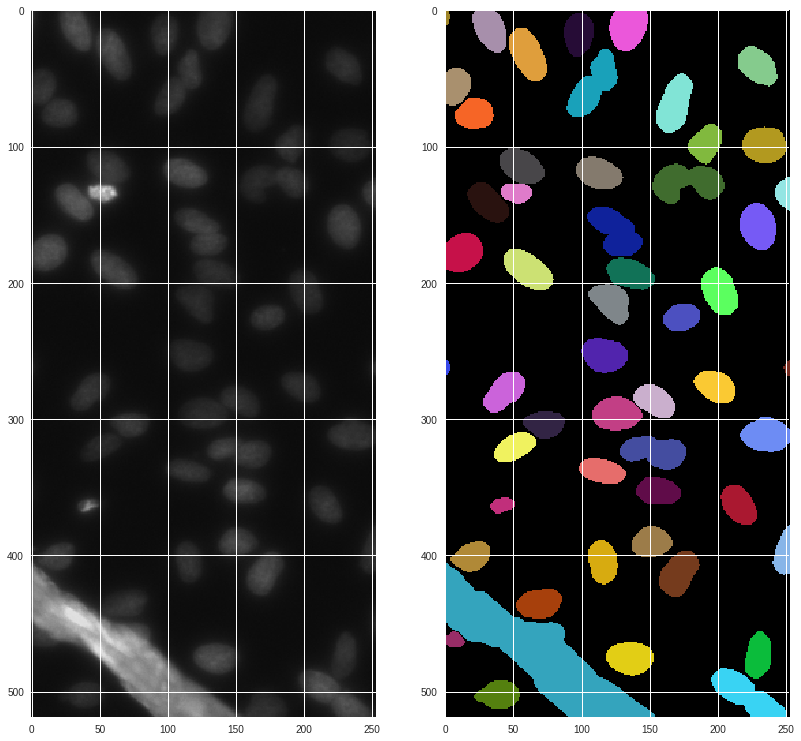

In [20]:
import matplotlib.pyplot as plt
import random

def random_color_img(label):
    image = np.zeros(label.shape + (3,), dtype=np.uint8)
    for i in range(1,label.max()):
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        color = np.array([r,g,b])
        image[label==i] = color
    
    return image
        
    

ix_ = np.random.randint(0, len(test_list))
print(ix_)
fig = plt.figure(figsize=(21,21))
plt.subplot(1, 3, 1)
plt.imshow(test_list[ix_])
plt.subplot(1, 3, 2)
plt.imshow(random_color_img(masks_to_label(test_predictions[ix_])))

plt.show()

In [0]:
#Rewriting the mIOU function to account for correct number of ground truth mask
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = masks_to_label(y_true_in)
    y_pred = masks_to_label(y_pred_in)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = len(y_true_in)
    metric = []
    for batch in range(batch_size):
        #print(y_true_in[batch].shape, y_pred_in[batch].shape)
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
#     return np.array(np.mean(metric), dtype=np.float32)
    return metric


In [17]:
mIOU = np.array(iou_metric_batch(test_gt, test_predictions))
print('The mean IOU is {}'.format(np.mean(mIOU)))

The mean IOU is 0.33602256600168284


(256, 256) bool True False
(256, 256) bool True False


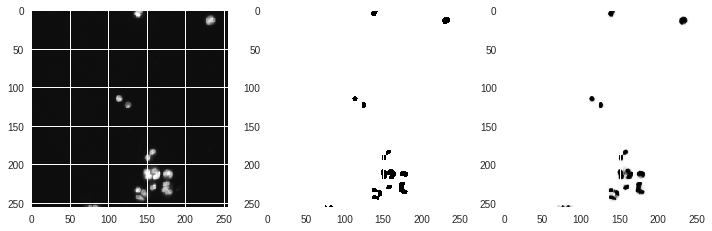

In [0]:
import matplotlib.pyplot as plt
image = test_list[10]

res_tta = tta_predict(image, model,0.5)
print(res_tta.shape, res_tta.dtype, res_tta.max(), res_tta.min())
simage = image[np.newaxis]
#Predict
raw_pred = model.predict(simage, verbose=0) 
raw_pred = np.squeeze(raw_pred)

fig = plt.figure(figsize=(12,12))
plt.subplot(131)
plt.imshow(image)
plt.subplot(132)
plt.imshow(res_tta)
plt.subplot(133)
plt.imshow(raw_pred)
plt.show()